In [1]:
import pandas as pd
import numpy as np
import os
import re
import json
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# 1. Load Data

## 1.1 Load Bond Spreads Data

In [2]:
df_spreads = pd.read_csv('BondSpreads.csv', header = 0, index_col = False)

In [3]:
df_spreads['EquityTicker'].unique()

array(['000333 CH', '0013 JP', '002415 CH', ..., 'ZPG LN', 'ZQKSQ US',
       'ZURN SW'], dtype=object)

In [4]:
df_spreads.iloc[:,:4].describe()

,EquityTicker,BondTicker,CorpID,ISIN
count,7750,7750,7750,7750
unique,1219,1469,7529,7529
top,4068781Z FP,ACAFP,EC774190 Corp,XS0435879605
freq,123,118,2,2


In [5]:
spread_date = list(df_spreads.columns[4:].values)
spread_date[-10:]

['13/04/2018',
 '16/04/2018',
 '17/04/2018',
 '18/04/2018',
 '19/04/2018',
 '20/04/2018',
 '23/04/2018',
 '24/04/2018',
 '25/04/2018',
 '26/04/2018']

In [6]:
df_spreads2 = pd.melt(df_spreads, 
                id_vars = ['EquityTicker', 'BondTicker', 'CorpID', 'ISIN'],
                value_vars = spread_date,
                var_name = 'Date',
                value_name = 'Spread')
df_spreads2 = df_spreads2.drop_duplicates()
df_spreads2.head()
df_spreads2.shape

(11830201, 6)

In [7]:
df_spreads2['Date'] = pd.to_datetime(df_spreads2['Date'], format='%d/%m/%Y')

In [8]:
df_spreads2['Year'] = df_spreads2['Date'].dt.year
df_spreads2['Quarter'] = df_spreads2['Date'].dt.quarter
df_spreads2['Month'] = df_spreads2['Date'].dt.month
df_spreads2['Weekday'] = df_spreads2['Date'].dt.weekday_name
df_spreads2['TickerCountry'] = df_spreads2['EquityTicker'].apply(lambda x:x.split(' ')[1])
df_spreads2 = df_spreads2.query('Year >= 2016')

In [9]:
df_spreads2.drop_duplicates().shape

(4561576, 11)

In [10]:
df_spreads2.describe()

,Spread,Year,Quarter,Month
count,3.613978e+06,4.561576e+06,4.561576e+06,4.561576e+06
mean,-3.667132e+03,2.016707e+03,2.323932e+00,5.950300e+00
std,2.133982e+05,6.961639e-01,1.137255e+00,3.513895e+00
min,-2.514163e+07,2.016000e+03,1.000000e+00,1.000000e+00
25%,8.441000e+00,2.016000e+03,1.000000e+00,3.000000e+00
50%,4.565000e+01,2.017000e+03,2.000000e+00,6.000000e+00
75%,1.396220e+02,2.017000e+03,3.000000e+00,9.000000e+00
max,3.397119e+06,2.018000e+03,4.000000e+00,1.200000e+01


In [11]:
df_spreads2[['Date','Spread']].groupby('Date').agg({'Spread': lambda x: x.isnull().sum()}).tail()

,Spread
Date,
2018-04-20,739.0
2018-04-23,739.0
2018-04-24,739.0
2018-04-25,739.0
2018-04-26,1180.0


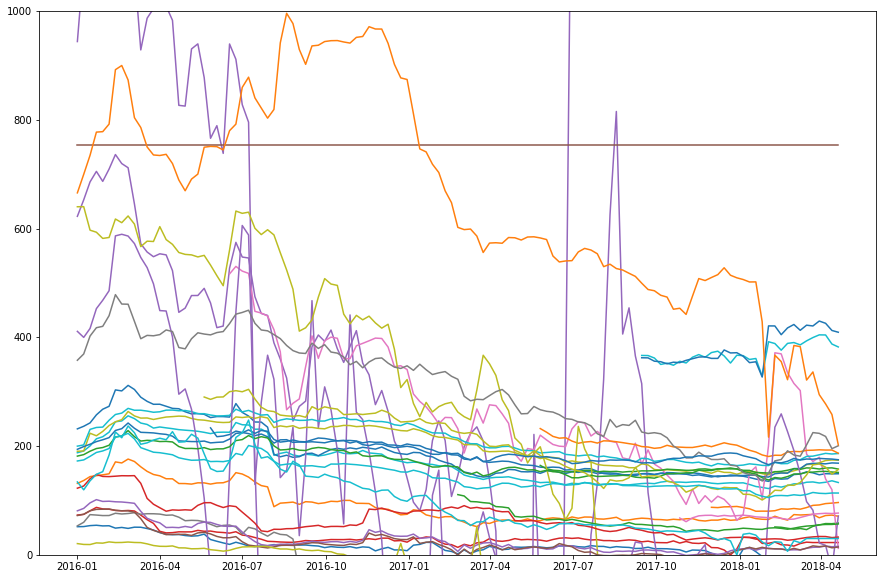

In [12]:
plt.figure(figsize=(15,10))
for i in df_spreads2['CorpID'].unique()[250:300]:
    plt.plot(df_spreads2.loc[(df_spreads2['CorpID'] == i) & (df_spreads2['Weekday'] == 'Friday')]['Date'], 
             df_spreads2.loc[(df_spreads2['CorpID'] == i) & (df_spreads2['Weekday'] == 'Friday')]['Spread'])
plt.ylim(0, 1000)
plt.show()

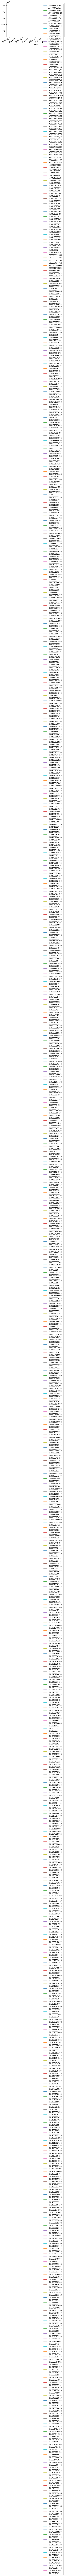

In [13]:
fig, ax = plt.subplots()
for label, grp in df_spreads2[:1000].groupby('ISIN'):
    grp.plot(x = grp.Date, y = 'Spread',ax = ax, label = label)
plt.show()

In [99]:
df_spreads2.groupby('ISIN')

## Get Industry Sector of the Ticker

In [123]:
from urllib import request
from lxml.html import parse

'''
Returns a tuple (Sector, Indistry)
Usage: GFinSectorIndustry('IBM')
'''
def GFinSectorIndustry(name):
  tree = parse(request('http://www.google.com/finance?&q='+name))
  return tree.xpath("//a[@id='sector']")[0].text, tree.xpath("//a[@id='sector']")[0].getnext().text

In [124]:
GFinSectorIndustry('AAPL')

TypeError: 'module' object is not callable

In [ ]:
income_calls = os.listdir(path="Fixedicomecalls")
len(income_calls)

In [ ]:
income_calls[1835] # end of Feb 2018
income_calls[1280:1289] # end of Jan 2018

In [ ]:
ic_dates = [s[:8] for s in income_calls[:1835]]
len(np.unique(ic_dates))

In [ ]:
np.unique(ic_dates)

## 2. Read and Parse PDF Files

In [21]:
import PyPDF2
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFPageInterpreter, PDFResourceManager, resolve1
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
from io import BytesIO

In [22]:
pdfPath = "Fixedicomecalls"
os.listdir(pdfPath)[:10]

['20170802_8303_EarningsCall_FS000000002369321225.pdf',
 '20170802_AKE_EarningsCall_FS000000002368092514.pdf',
 '20170802_APTV_EarningsCall_FS000000002392228574.pdf',
 '20170802_APTV_EarningsCall_FS000000002392228586.pdf',
 '20170802_BDC_EarningsCall_FS000000002368972975.pdf',
 '20170802_BG_EarningsCall_FS000000002363796472.pdf',
 '20170802_BG_EarningsCall_FS000000002363796496.pdf',
 '20170802_CG_EarningsCall_FS000000002363452948.pdf',
 '20170802_DBK_EarningsCall_FS000000002363334541.pdf',
 '20170802_DBK_EarningsCall_FS000000002363334547.pdf']

In [ ]:
# Open a PDF file.
fp = open(os.path.join(pdfPath, '20171030_HSBA_EarningsCall1_DN000000002378855205.pdf'), 'rb')
# Create a PDF parser object associated with the file object.
parser = PDFParser(fp)
# Create a PDF document object that stores the document structure.
# Supply the password for initialization.
document = PDFDocument(parser)
# Check if the document allows text extraction. If not, abort.
if not document.is_extractable:
    raise PDFTextExtractionNotAllowed

resmgr = PDFResourceManager()
restr = BytesIO()
codec = 'utf-8'
laparams = LAParams()
device = TextConverter(resmgr, restr, codec=codec, laparams=laparams)
interpreter = PDFPageInterpreter(resmgr, device)

for page in PDFPage.get_pages(fp):
    interpreter.process_page(page)
    data = restr.getvalue()
        
        
#        for obj in device.get_result():
#            if isinstance(obj, (LTTextBox, LTTextLine)):
#                obj.get_text()

In [ ]:
data

In [23]:
def lsplit(seq,splitters): # define function to split a list
    #seq=list(seq)
    if splitters and seq:
        splitters=set(splitters).intersection(seq)
        if splitters:
            result=[]
            begin=0
            for end in range(len(seq)):
                if seq[end] in splitters:
                    if end > begin:
                        result.append(seq[begin:end])
                    begin=end+1
            if begin<len(seq):
                result.append(seq[begin:])
            return result
    return [seq]

In [24]:
def parseEarningCall(folder, filename):
    output = {}
    
    output['file_name'] = filename
    
    fp = open(os.path.join(folder,filename), 'rb')
    parser = PDFParser(fp) #parse file object
    document = PDFDocument(parser) #parse PDF document structure
    
    # Extract PDF contents
    resmgr = PDFResourceManager()
    restr = BytesIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(resmgr, restr, codec=codec, laparams=laparams)
    interpreter = PDFPageInterpreter(resmgr, device)
    
    output['title'] = document.info[0]['Title'].decode('utf-8') # get document title
    output['page_count'] = resolve1(document.catalog['Pages'])['Count'] # get total number of page
    
    # Extract text in every page
    for page in PDFPage.get_pages(fp):
        interpreter.process_page(page)
        txt = restr.getvalue().decode('utf-8')
    
    output['call_date'] = re.search(r'Date\: (.*?)Event Description\:', txt).group(1) # extract Earning call date
    
    # some texts do not contain a company name
    try:
        output['company_name'] = re.search(r'\nCompany Name\: (.*?)Company Ticker\:', txt).group(1)
    except:
        output['company_name'] = np.nan
    
    output['company_ticker'] = re.search(r'Company Ticker\: (.*?)Date\:', txt).group(1) #parse ticker
    output['market_cap'] = re.search(r'Market Cap\: (.*?)Current PX\:', txt).group(1) #parse market cap
    output['currentPX'] = re.search(r'Current PX\: (.*?)YTD Change\(\$\)\:', txt).group(1) #parse current PX
    output['YTDchangeVal'] = re.search(r'YTD Change\(\$\)\: (.*?)YTD Change\(\%\)\:', txt).group(1) #parse PX YTD change
    output['YTDchangePct'] = re.search(r'YTD Change\(\%\)\: (.*?)Bloomberg Estimates\s\-\sEPS', txt).group(1) #parse PX YTD % change
    
    output['text'] = re.sub('Company Name\:(.*?)\\x0c', '\x0c', txt) #remove document header
    
    # Parse all participants in the conference call and split the company participants with the others
    participants = re.search(r'Company(\s|\S)Participants((.|\n)*)(MANAGEMENT DISCUSSION|Presentation){1}', txt).group(0).replace('(cid:127) ','').split('\n')
    participants = list(filter(None, participants))
    
    if 'Other Participants' in participants:
        parSplit = lsplit(participants[1:-1], ['Other Participants'])
        output['companyParticipants'] = parSplit[0]
        output['otherParticipants'] = parSplit[1]
    else:
        output['companyParticipants'], output['otherParticipants'] = participants[1:-1], []
    
    return output

In [ ]:
#ECfiles = {}

for i, doc in enumerate(income_calls[663:1289]):
    print(i, doc)
    ECfiles[doc] = parseEarningCall(pdfPath, doc)

In [ ]:
# Temporary save the PDF extracts
psave = open('ECdetails.p', 'wb')
pickle.dump(ECfiles, psave)
psave.close()

In [14]:
ECfiles = pickle.load(open('ECdetails.p', 'rb'))

In [15]:
df_ec = pd.DataFrame.from_dict(ECfiles, orient='index').reset_index()
df_ec[df_ec["index"] != df_ec["file_name"]] #check if the index is always the same as filename

,index,YTDchangeVal,page_count,currentPX,YTDchangePct,title,otherParticipants,company_ticker,market_cap,file_name,text,company_name,companyParticipants,call_date


In [16]:
# extract the total number of participants
op_new = []
for l in df_ec['otherParticipants']:
    try:
        if 'Presentation' in l:
            target = l.index('Presentation')
            op_new.append(l[:target])
        else:
            target = l.index('MANAGEMENT DISCUSSION SECTION')
            op_new.append(l[:target])
    except:
        op_new.append(l)
df_ec['otherParticipants'] = op_new
df_ec['count_companyParticipants'] = df_ec['companyParticipants'].map(len)
df_ec.loc[df_ec['otherParticipants'].isnull(),['otherParticipants']] = df_ec.loc[df_ec['otherParticipants'].isnull(),'otherParticipants'].apply(lambda x: [])
df_ec['count_otherParticipants'] = df_ec['otherParticipants'].map(len)

In [17]:
df_ec[["company_ticker", "file_name", "call_date"]].groupby(['company_ticker', 'call_date']).count().reset_index().head(10)

,company_ticker,call_date,file_name
0,005930 KS,2017-10-30,2
1,005930 KS,2018-01-30,2
2,0916972D L,2017-11-17,1
3,1 HK,2017-08-03,1
4,1025Z LN,2017-08-03,1
5,1COV GR,2017-10-24,1
6,2262691Z U,2017-08-04,1
7,2262691Z U,2017-11-03,1
8,2914 JP,2017-08-03,1
9,2914 JP,2017-11-02,1


In [18]:
df_ec['company_ticker'].unique()[:10]

array(['8303 JP', 'AKE FP', 'APTV US', 'BDC US', 'BG US', 'CG US',
       'DBK GR', 'DTY LN', 'EQIX US', 'FIS US'], dtype=object)

In [19]:
# Filter out all tickers that have no earning call document
df_spreads = df_spreads.loc[df_spreads['EquityTicker'].isin(df_ec['company_ticker'].unique())].reset_index(drop=True)

In [20]:
df_ec = df_ec.loc[df_ec['company_ticker'].isin(df_spreads['EquityTicker'].unique())].reset_index(drop=True)

In [21]:
df_ec['text'] = df_ec['text'].str.replace('\nCompany Name\: (.*?)Bloomberg Estimates - Sales(.*?)Current Year\:', '')
df_ec['text'] = df_ec['text'].str.replace('This transcript may not be 100 percent accurate and may(.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*\n.*)', '')

In [22]:
df_ec.head()

,index,YTDchangeVal,page_count,currentPX,YTDchangePct,title,otherParticipants,company_ticker,market_cap,file_name,text,company_name,companyParticipants,call_date,count_companyParticipants,count_otherParticipants
0,20170802_8303_EarningsCall_FS00000000236932122...,-21,3,175,-10.714,Q1 2017 Earnings Call - Q&A,[],8303 JP,"481,310.71",20170802_8303_EarningsCall_FS00000000236932122...,Q1 2017 Earnings Call - Q&A\n\nCompany Partici...,Shinsei Bank,"[Hiroshi Ishii, Sanjeev Gupta]",2017-08-02,2,0
1,20170802_AKE_EarningsCall_FS000000002368092514...,+2.50,13,95.44,+2.690,Q2 2017 Earnings Call,"[Thomas P. Wrigglesworth, Patrick Lambert, Emm...",AKE FP,"7,231.86",20170802_AKE_EarningsCall_FS000000002368092514...,Q2 2017 Earnings Call\n\nCompany Participants\...,Arkema,"[Thierry le Hénaff, Thierry Lemonnier]",2017-08-02,2,8
2,20170802_APTV_EarningsCall_FS00000000239222857...,+6.52,18,91.35,+7.686,Q2 2017 Earnings Call,"[Rod Lache, Joseph Spak, David Leiker, Itay Mi...",APTV US,"24,284.47",20170802_APTV_EarningsCall_FS00000000239222857...,Q2 2017 Earnings Call\n\nCompany Participants\...,Aptiv PLC,"[Elena D. Rosman, Kevin P. Clark, Joseph R. Ma...",2017-08-02,3,10
3,20170802_APTV_EarningsCall_FS00000000239222858...,+6.52,19,91.35,+7.686,Q2 2017 Earnings Call,"[Rod Lache, Joseph Spak, David Leiker, Itay Mi...",APTV US,"24,284.47",20170802_APTV_EarningsCall_FS00000000239222858...,Q2 2017 Earnings Call\n\nCompany Participants\...,Aptiv PLC,"[Elena D. Rosman, Kevin P. Clark, Joseph R. Ma...",2017-08-02,3,10
4,20170802_BDC_EarningsCall_FS000000002368972975...,-1.60,13,73.17,-2.140,Q2 2017 Earnings Call,"[John Quealy, Steven Fox, Shawn M. Harrison, M...",BDC US,"3,095.04",20170802_BDC_EarningsCall_FS000000002368972975...,Q2 2017 Earnings Call\n\nCompany Participants\...,Belden Inc,"[Kevin Maczka, John S. Stroup, Hendrikus Derksen]",2017-08-02,3,8


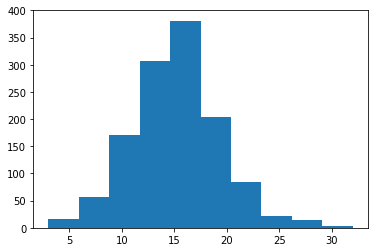

In [23]:
plt.hist(df_ec['page_count'])
plt.show()

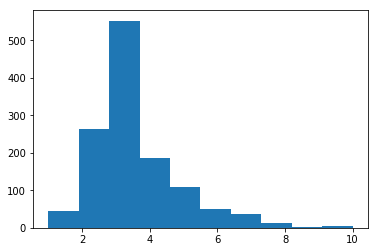

In [24]:
plt.hist(df_ec['count_companyParticipants'])
plt.show()

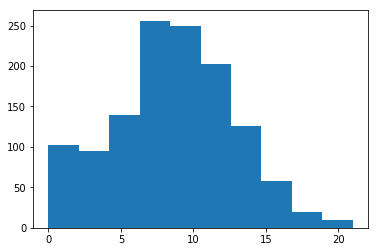

In [25]:
plt.hist(df_ec['count_otherParticipants'])
plt.show()

In [26]:
df_ec['count_otherParticipants'].describe()
x = df_ec.loc[df_ec['count_otherParticipants'] > 2, 'otherParticipants']
x[869]

['Arun Viswanathan, Analyst',
 'Joel Jackson, Analyst',
 'David Wang, Analyst',
 'P.J. Juvekar, Analyst',
 'Jim Sheehan, Analyst',
 'Dylan Campbell, Analyst',
 'Matthew Skowronski, Analyst',
 'Neel Kumar, Analyst',
 'Colin Rusch, Analyst',
 'Dimitry Silversteyn, Analyst',
 'John Roberts, Analyst',
 'Chris Kapsch, Analyst',
 'Jeffrey Zekauskas, Analyst']

In [27]:
df_ec['TickerCountry'] = df_ec['company_ticker'].apply(lambda x:x.split(' ')[1])

In [28]:
df_ec.head()

,index,YTDchangeVal,page_count,currentPX,YTDchangePct,title,otherParticipants,company_ticker,market_cap,file_name,text,company_name,companyParticipants,call_date,count_companyParticipants,count_otherParticipants,TickerCountry
0,20170802_8303_EarningsCall_FS00000000236932122...,-21,3,175,-10.714,Q1 2017 Earnings Call - Q&A,[],8303 JP,"481,310.71",20170802_8303_EarningsCall_FS00000000236932122...,Q1 2017 Earnings Call - Q&A\n\nCompany Partici...,Shinsei Bank,"[Hiroshi Ishii, Sanjeev Gupta]",2017-08-02,2,0,JP
1,20170802_AKE_EarningsCall_FS000000002368092514...,+2.50,13,95.44,+2.690,Q2 2017 Earnings Call,"[Thomas P. Wrigglesworth, Patrick Lambert, Emm...",AKE FP,"7,231.86",20170802_AKE_EarningsCall_FS000000002368092514...,Q2 2017 Earnings Call\n\nCompany Participants\...,Arkema,"[Thierry le Hénaff, Thierry Lemonnier]",2017-08-02,2,8,FP
2,20170802_APTV_EarningsCall_FS00000000239222857...,+6.52,18,91.35,+7.686,Q2 2017 Earnings Call,"[Rod Lache, Joseph Spak, David Leiker, Itay Mi...",APTV US,"24,284.47",20170802_APTV_EarningsCall_FS00000000239222857...,Q2 2017 Earnings Call\n\nCompany Participants\...,Aptiv PLC,"[Elena D. Rosman, Kevin P. Clark, Joseph R. Ma...",2017-08-02,3,10,US
3,20170802_APTV_EarningsCall_FS00000000239222858...,+6.52,19,91.35,+7.686,Q2 2017 Earnings Call,"[Rod Lache, Joseph Spak, David Leiker, Itay Mi...",APTV US,"24,284.47",20170802_APTV_EarningsCall_FS00000000239222858...,Q2 2017 Earnings Call\n\nCompany Participants\...,Aptiv PLC,"[Elena D. Rosman, Kevin P. Clark, Joseph R. Ma...",2017-08-02,3,10,US
4,20170802_BDC_EarningsCall_FS000000002368972975...,-1.60,13,73.17,-2.140,Q2 2017 Earnings Call,"[John Quealy, Steven Fox, Shawn M. Harrison, M...",BDC US,"3,095.04",20170802_BDC_EarningsCall_FS000000002368972975...,Q2 2017 Earnings Call\n\nCompany Participants\...,Belden Inc,"[Kevin Maczka, John S. Stroup, Hendrikus Derksen]",2017-08-02,3,8,US


# 2. NLP

In [29]:
import nltk
import inflect
from nltk.corpus import stopwords, wordnet
from textblob import TextBlob

In [30]:
#check number of words
df_ec['word_count'] = df_ec['text'].apply(lambda x: len(str(x).split(" ")))

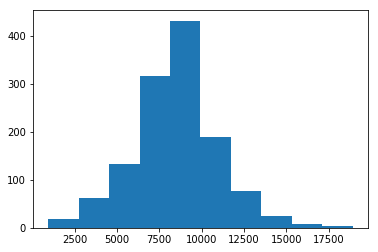

In [31]:
plt.hist(df_ec['word_count'])
plt.show()

In [32]:
stop = stopwords.words('english')
df_ec['stop_count'] = df_ec['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df_ec['stop_pct'] = df_ec['stop_count'] / df_ec['word_count']

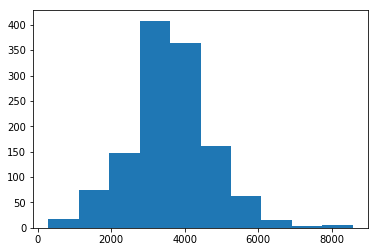

In [33]:
plt.hist(df_ec['stop_count'])
plt.show()

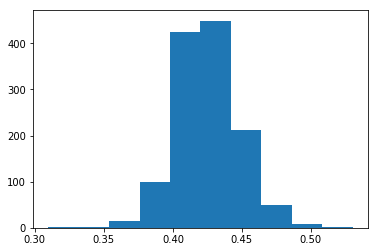

In [34]:
plt.hist(df_ec['stop_pct'])
plt.show()

In [35]:
df_ec['count_numbers'] = df_ec['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

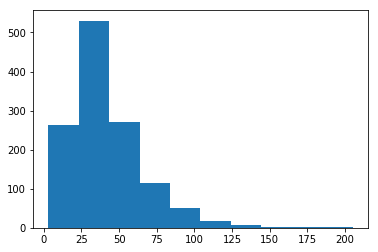

In [36]:
plt.hist(df_ec['count_numbers'])
plt.show()

In [37]:
stopwords.words('english')[10]

"you've"

## 2.1 Data Cleaning

### Split discussion and Q&A section of the text

In [38]:
splitter = r"(\n\x0cQuestions And Answers\n|\nQuestions And Answers\n|\nQ\&A\n|\nQUESTION AND ANSWER SECTION\n|\n\x0cQ&A\n|\n\x0cQUESTION AND ANSWER SECTION\n)"
df_ec[['text_discussion', 'text_qa']] = df_ec['text'].str.split(splitter, expand=True).iloc[:,[0,2]]
df_ec['word_count_dis'] = df_ec['text_discussion'].apply(lambda x: len(str(x).split(" ")))
df_ec['word_count_qa'] = df_ec['text_qa'].apply(lambda x: len(str(x).split(" ")))
df_ec.head()

,index,YTDchangeVal,page_count,currentPX,YTDchangePct,title,otherParticipants,company_ticker,market_cap,file_name,...,count_otherParticipants,TickerCountry,word_count,stop_count,stop_pct,count_numbers,text_discussion,text_qa,word_count_dis,word_count_qa
0,20170802_8303_EarningsCall_FS00000000236932122...,-21,3,175,-10.714,Q1 2017 Earnings Call - Q&A,[],8303 JP,"481,310.71",20170802_8303_EarningsCall_FS00000000236932122...,...,0,JP,1078,372,0.345083,7,Q1 2017 Earnings Call - Q&A\n\nCompany Partici...,\nOperator\nThank you. Today's question-and-an...,999,80
1,20170802_AKE_EarningsCall_FS000000002368092514...,+2.50,13,95.44,+2.690,Q2 2017 Earnings Call,"[Thomas P. Wrigglesworth, Patrick Lambert, Emm...",AKE FP,"7,231.86",20170802_AKE_EarningsCall_FS000000002368092514...,...,8,FP,7455,3336,0.447485,18,Q2 2017 Earnings Call\n\nCompany Participants\...,\nOperator\n[Operator Instructions] We have a ...,2426,5030
2,20170802_APTV_EarningsCall_FS00000000239222857...,+6.52,18,91.35,+7.686,Q2 2017 Earnings Call,"[Rod Lache, Joseph Spak, David Leiker, Itay Mi...",APTV US,"24,284.47",20170802_APTV_EarningsCall_FS00000000239222857...,...,10,US,10038,3846,0.383144,55,Q2 2017 Earnings Call\n\nCompany Participants\...,\n Operator\n[Operator Instructions] Our first...,3671,6368
3,20170802_APTV_EarningsCall_FS00000000239222858...,+6.52,19,91.35,+7.686,Q2 2017 Earnings Call,"[Rod Lache, Joseph Spak, David Leiker, Itay Mi...",APTV US,"24,284.47",20170802_APTV_EarningsCall_FS00000000239222858...,...,10,US,9307,3573,0.383905,46,Q2 2017 Earnings Call\n\nCompany Participants\...,<Q - Rod Lache>: I just had a couple questions...,3388,5917
4,20170802_BDC_EarningsCall_FS000000002368972975...,-1.60,13,73.17,-2.140,Q2 2017 Earnings Call,"[John Quealy, Steven Fox, Shawn M. Harrison, M...",BDC US,"3,095.04",20170802_BDC_EarningsCall_FS000000002368972975...,...,8,US,7360,3016,0.409783,43,Q2 2017 Earnings Call\n\nCompany Participants\...,"\nOperator\nThank you, sir. [Operator Instruct...",2407,4954


### Replace contractions and change to lower case

In [39]:
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

In [40]:
df_ec['text_qa'] = df_ec['text_qa'].fillna('')
df_ec['text_dis_clean'] = df_ec['text_discussion'].apply(lambda x: replaceContraction(x.lower()))
df_ec['text_qa_clean'] = df_ec['text_qa'].apply(lambda x: replaceContraction(x.lower()))

In [41]:
df_ec.head()

,index,YTDchangeVal,page_count,currentPX,YTDchangePct,title,otherParticipants,company_ticker,market_cap,file_name,...,word_count,stop_count,stop_pct,count_numbers,text_discussion,text_qa,word_count_dis,word_count_qa,text_dis_clean,text_qa_clean
0,20170802_8303_EarningsCall_FS00000000236932122...,-21,3,175,-10.714,Q1 2017 Earnings Call - Q&A,[],8303 JP,"481,310.71",20170802_8303_EarningsCall_FS00000000236932122...,...,1078,372,0.345083,7,Q1 2017 Earnings Call - Q&A\n\nCompany Partici...,\nOperator\nThank you. Today's question-and-an...,999,80,q1 2017 earnings call - qanda\n\ncompany parti...,\noperator\nthank you. today is question-and-a...
1,20170802_AKE_EarningsCall_FS000000002368092514...,+2.50,13,95.44,+2.690,Q2 2017 Earnings Call,"[Thomas P. Wrigglesworth, Patrick Lambert, Emm...",AKE FP,"7,231.86",20170802_AKE_EarningsCall_FS000000002368092514...,...,7455,3336,0.447485,18,Q2 2017 Earnings Call\n\nCompany Participants\...,\nOperator\n[Operator Instructions] We have a ...,2426,5030,q2 2017 earnings call\n\ncompany participants\...,\noperator\n[operator instructions] we have a ...
2,20170802_APTV_EarningsCall_FS00000000239222857...,+6.52,18,91.35,+7.686,Q2 2017 Earnings Call,"[Rod Lache, Joseph Spak, David Leiker, Itay Mi...",APTV US,"24,284.47",20170802_APTV_EarningsCall_FS00000000239222857...,...,10038,3846,0.383144,55,Q2 2017 Earnings Call\n\nCompany Participants\...,\n Operator\n[Operator Instructions] Our first...,3671,6368,q2 2017 earnings call\n\ncompany participants\...,\n operator\n[operator instructions] our first...
3,20170802_APTV_EarningsCall_FS00000000239222858...,+6.52,19,91.35,+7.686,Q2 2017 Earnings Call,"[Rod Lache, Joseph Spak, David Leiker, Itay Mi...",APTV US,"24,284.47",20170802_APTV_EarningsCall_FS00000000239222858...,...,9307,3573,0.383905,46,Q2 2017 Earnings Call\n\nCompany Participants\...,<Q - Rod Lache>: I just had a couple questions...,3388,5917,q2 2017 earnings call\n\ncompany participants\...,<q - rod lache>: i just had a couple questions...
4,20170802_BDC_EarningsCall_FS000000002368972975...,-1.60,13,73.17,-2.140,Q2 2017 Earnings Call,"[John Quealy, Steven Fox, Shawn M. Harrison, M...",BDC US,"3,095.04",20170802_BDC_EarningsCall_FS000000002368972975...,...,7360,3016,0.409783,43,Q2 2017 Earnings Call\n\nCompany Participants\...,"\nOperator\nThank you, sir. [Operator Instruct...",2407,4954,q2 2017 earnings call\n\ncompany participants\...,"\noperator\nthank you, sir. [operator instruct..."


### Replace negation with Antonym

In [42]:
from nltk.corpus import wordnet

def replace(word, pos=None):
    """ Creates a set of all antonyms for the word and if there is only one antonym, it returns it """
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            for antonym in lemma.antonyms():
                antonyms.add(antonym.name())
    if len(antonyms) == 1:
        return antonyms.pop()
    else:
        return None

def replaceNegations(text):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    i, l = 0, len(text)
    words = []
    while i < l:
        word = text[i]
        if word == 'not' and i+1 < l:
            ant = replace(text[i+1])
            if ant:
                words.append(ant)
                i += 2
                continue
        words.append(word)
        i += 1
    return words

def tokenize1(text):
    tokens = nltk.word_tokenize(text)
    tokens = replaceNegations(tokens)
    text = " ".join(tokens)
    return text

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

#text_replaceNegations = pd.DataFrame(columns=['TextBefore', 'TextAfter', 'Changed'])
#text_replaceNegations['TextBefore'] = text.copy()

In [43]:
df_ec['text_dis_clean'] = df_ec['text_dis_clean'].apply(lambda x: tokenize1(x))
df_ec['text_qa_clean'] = df_ec['text_qa_clean'].apply(lambda x: tokenize1(x))

### Replace punctuations

In [44]:
df_ec['text_dis_clean'] = df_ec['text_dis_clean'].str.replace('[^\w\s]','')
df_ec['text_qa_clean'] = df_ec['text_qa_clean'].str.replace('[^\w\s]','')

In [45]:
df_ec['text_qa_clean'][530]

'operator thank you  ladies and gentlemen  at this time  we will begin the questionandanswer session   operator instructions  the first question comes from line of mr jain  please state your name  company name  followed by your question   q  sachin jain   hi  sachin jain from bank of america  thanks for taking my questions  a few  please  firstly  werner  i wanted you to comment on the timing and size of rights issue as you see it now given the slightly longer european timelines and 116 billion raised through the covestro proceeds and crop asset divestments  i understand your comments on the wires about the lost cash flow  but even accounting for that it seems that it can be smaller versus 15 billion that you have previously talked about  secondly  a clarification comment again from the wires that you are looking at further asset divestments  is that over and above the remaining covestro stake for the next lockup in december  and then two business questions  on xarelto exus  it grew 4 

### Remove Stopwords

In [46]:
df_ec['text_dis_clean'] = df_ec['text_dis_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_ec['text_qa_clean'] = df_ec['text_qa_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [47]:
TextBlob(df_ec['text_qa_clean'][10]).sentiment

Sentiment(polarity=0.10504798510313214, subjectivity=0.392875976148035)

## Calculate Readabililty of the Text

In [48]:
import textstat

In [49]:
df_ec['gunning_fog_dis'] = df_ec['text_discussion'].apply(lambda x: textstat.gunning_fog(x))
df_ec['gunning_fog_qa'] = df_ec['text_qa'].apply(lambda x: textstat.gunning_fog(x))

In [50]:
df_ec['fkg_dis'] = df_ec['text_discussion'].apply(lambda x: textstat.flesch_kincaid_grade(x))
df_ec['fkg_qa'] = df_ec['text_qa'].apply(lambda x: textstat.flesch_kincaid_grade(x))

In [51]:
df_ec.head(10)

,index,YTDchangeVal,page_count,currentPX,YTDchangePct,title,otherParticipants,company_ticker,market_cap,file_name,...,text_discussion,text_qa,word_count_dis,word_count_qa,text_dis_clean,text_qa_clean,gunning_fog_dis,gunning_fog_qa,fkg_dis,fkg_qa
0,20170802_8303_EarningsCall_FS00000000236932122...,-21,3,175,-10.714,Q1 2017 Earnings Call - Q&A,[],8303 JP,"481,310.71",20170802_8303_EarningsCall_FS00000000236932122...,...,Q1 2017 Earnings Call - Q&A\n\nCompany Partici...,\nOperator\nThank you. Today's question-and-an...,999,80,q1 2017 earnings call qanda company participan...,operator thank today questionandanswer session...,15.52,14.91,11.4,9.1
1,20170802_AKE_EarningsCall_FS000000002368092514...,+2.50,13,95.44,+2.690,Q2 2017 Earnings Call,"[Thomas P. Wrigglesworth, Patrick Lambert, Emm...",AKE FP,"7,231.86",20170802_AKE_EarningsCall_FS000000002368092514...,...,Q2 2017 Earnings Call\n\nCompany Participants\...,\nOperator\n[Operator Instructions] We have a ...,2426,5030,q2 2017 earnings call company participants cid...,operator operator instructions question thomas...,18.51,11.87,15.1,8.6
2,20170802_APTV_EarningsCall_FS00000000239222857...,+6.52,18,91.35,+7.686,Q2 2017 Earnings Call,"[Rod Lache, Joseph Spak, David Leiker, Itay Mi...",APTV US,"24,284.47",20170802_APTV_EarningsCall_FS00000000239222857...,...,Q2 2017 Earnings Call\n\nCompany Participants\...,\n Operator\n[Operator Instructions] Our first...,3671,6368,q2 2017 earnings call company participants cid...,operator operator instructions first question ...,18.04,10.60,15.7,8.3
3,20170802_APTV_EarningsCall_FS00000000239222858...,+6.52,19,91.35,+7.686,Q2 2017 Earnings Call,"[Rod Lache, Joseph Spak, David Leiker, Itay Mi...",APTV US,"24,284.47",20170802_APTV_EarningsCall_FS00000000239222858...,...,Q2 2017 Earnings Call\n\nCompany Participants\...,<Q - Rod Lache>: I just had a couple questions...,3388,5917,q2 2017 earnings call company participants cid...,q rod lache couple questions one could clarify...,154.47,11.01,148.7,8.6
4,20170802_BDC_EarningsCall_FS000000002368972975...,-1.60,13,73.17,-2.140,Q2 2017 Earnings Call,"[John Quealy, Steven Fox, Shawn M. Harrison, M...",BDC US,"3,095.04",20170802_BDC_EarningsCall_FS000000002368972975...,...,Q2 2017 Earnings Call\n\nCompany Participants\...,"\nOperator\nThank you, sir. [Operator Instruct...",2407,4954,q2 2017 earnings call company participants cid...,operator thank sir operator instructions take ...,14.99,13.08,13.0,10.4
5,20170802_BG_EarningsCall_FS000000002363796472.pdf,+3.72,13,75.96,+5.150,Q2 2017 Earnings Call,"[Ann P. Duignan, Adam Samuelson, Heather Jones...",BG US,"10,680.14",20170802_BG_EarningsCall_FS000000002363796472.pdf,...,Q2 2017 Earnings Call\n\nCompany Participants\...,\nOperator\nThank you. We will now begin the q...,2759,5222,q2 2017 earnings call company participants cid...,operator thank begin questionandanswer session...,18.58,13.50,14.6,9.4
6,20170802_BG_EarningsCall_FS000000002363796496.pdf,+3.72,14,75.96,+5.150,Q2 2017 Earnings Call,"[Ann P. Duignan, Adam Samuelson, Heather Jones...",BG US,"10,680.14",20170802_BG_EarningsCall_FS000000002363796496.pdf,...,Q2 2017 Earnings Call\n\nCompany Participants\...,<Q - Ann P. Duignan>: My question I think this...,2496,4824,q2 2017 earnings call company participants cid...,q ann p duignan question think morning get goo...,188.06,14.95,180.0,10.7
7,20170802_CG_EarningsCall_FS000000002363452948.pdf,+6.60,13,21.85,+43.279,Q2 2017 Earnings Call,"[Craig Siegenthaler, Kenneth B. Worthington, W...",CG US,"7,273.85",20170802_CG_EarningsCall_FS000000002363452948.pdf,...,Q2 2017 Earnings Call\n\nCompany Participants\...,\nOperator\nThank you. [Operator Instructions]...,3162,4750,q2 2017 earnings call company participants cid...,operator thank operator instructions first que...,17.32,11.92,14.1,9.6
8,20170802_DBK_EarningsCall_FS000000002363334541...,-.23,9,15.166,-1.492,Q2 2017 Earnings Call - Fixed Income,"[Greg Case, Lee Street, Robert Louis Smalley, ...",DBK GR,"31,344.68",

In [52]:
df_ec['fkg_qa'].loc[df_ec['fkg_qa'] < 0] = 0

c:\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


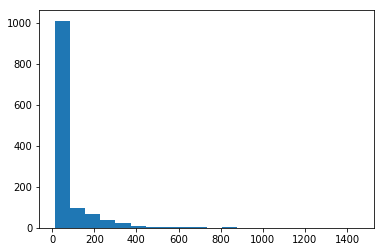

In [53]:
plt.hist(df_ec['gunning_fog_dis'], bins=20)
plt.show()

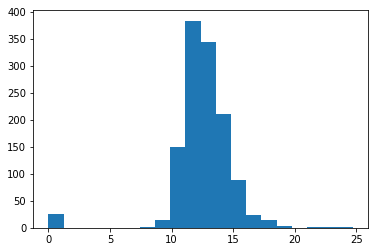

In [54]:
plt.hist(df_ec['gunning_fog_qa'], bins=20)
plt.show()

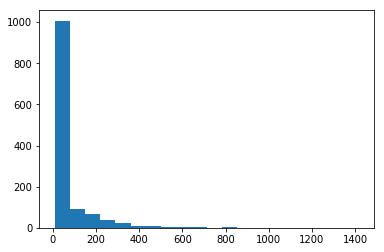

In [55]:
plt.hist(df_ec['fkg_dis'], bins=20)
plt.show()

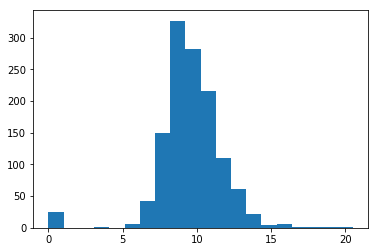

In [56]:
plt.hist(df_ec['fkg_qa'], bins=20)
plt.show()

### Remove Common words

In [57]:
global_word_freq = pd.Series(' '.join(df_ec['text_dis_clean'] + df_ec['text_qa_clean']).split()).value_counts()
dis_word_freq = pd.Series(' '.join(df_ec['text_dis_clean']).split()).value_counts()
qa_word_freq = pd.Series(' '.join(df_ec['text_qa_clean']).split()).value_counts()

In [58]:
dis_word_freq.head(10), qa_word_freq.head(10), global_word_freq.head(40)

(cid127      56990
 year        27020
 quarter     25886
 growth      24479
 million     19930
 business    17124
 also        14671
 us          13124
 2017        11588
 strong      11020
 dtype: int64, think       41996
 q           30196
 question    26256
 would       25844
 year        25325
 us          23020
 going       22929
 business    20802
 thank       19783
 see         19506
 dtype: int64, cid127      57581
 year        52334
 think       45317
 growth      41312
 quarter     41199
 business    37923
 us          36137
 would       32691
 also        30877
 q           29980
 see         28640
 million     28618
 question    26964
 going       26595
 good        24699
 thank       23446
 well        23239
 one         23158
 first       22982
 market      22113
 last        20046
 new         19709
 next        19262
 look        17500
 like        17498
 really      16318
 strong      16248
 expect      15790
 2017        15711
 continue    15640
 2018        15514
 mu

In [59]:
df_ec['text_dis_clean'] = df_ec['text_dis_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in global_word_freq[:20]))
df_ec['text_qa_clean'] = df_ec['text_qa_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in global_word_freq[:20]))

### Lemmatization

In [60]:
from textblob import Word

In [61]:
df_ec['text_dis_clean'] = df_ec['text_dis_clean'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df_ec['text_qa_clean'] = df_ec['text_qa_clean'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [62]:
df_ec['text_qa_clean'].head()

0    operator today questionandanswer session condu...
1    operator operator instruction thomas wrigglesw...
2    operator operator instruction come line rob si...
3    rod lache couple question could clarify outloo...
4    operator sir operator instruction take john qu...
Name: text_qa_clean, dtype: object

## Extract the Sentiment

In [63]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
nltk.download("vader_lexicon")
nltk.download("punkt")

[nltk_data] Downloading package vader_lexicon to C:\Users\Dinan
[nltk_data]     Amiendiartha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Dinan
[nltk_data]     Amiendiartha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [64]:
df_ec['sentiment_dis_1'] = df_ec['text_dis_clean'].apply(lambda x: TextBlob(x).sentiment[0])
df_ec['sentiment_qa_1'] = df_ec['text_qa_clean'].apply(lambda x: TextBlob(x).sentiment[0])

In [65]:
df_ec['sentiment_dis_0'] = df_ec['text_discussion'].apply(lambda x: TextBlob(x).sentiment[0])
df_ec['sentiment_qa_0'] = df_ec['text_qa'].apply(lambda x: TextBlob(x).sentiment[0])
#df_ec['sentiment_0'] = df_ec['text_clean'].apply(lambda x: TextBlob(x).sentiment[0])

In [66]:
df_ec['subj_dis_1'] = df_ec['text_dis_clean'].apply(lambda x: TextBlob(x).sentiment[1])
df_ec['subj_qa_1'] = df_ec['text_qa_clean'].apply(lambda x: TextBlob(x).sentiment[1])

In [67]:
analyzer = SentimentIntensityAnalyzer()

In [68]:
df_ec['text_qa_clean'][1:2].apply(lambda x: analyzer.polarity_scores(x))

1    {'neu': 0.766, 'compound': 0.9999, 'pos': 0.20...
Name: text_qa_clean, dtype: object

In [69]:
analyzer.polarity_scores(df_ec['text_qa_clean'][560]

SyntaxError: unexpected EOF while parsing (<ipython-input-69-499e0d16be20>, line 1)

In [181]:
df_ec.head()

,index,call_date,title,company_name,companyParticipants,file_name,YTDchangePct,company_ticker,market_cap,currentPX,...,gunning_fog_dis,gunning_fog_qa,fkg_dis,fkg_qa,sentiment_dis_1,sentiment_qa_1,sentiment_dis_0,sentiment_qa_0,subj_dis_1,subj_qa_1
0,20170802_8303_EarningsCall_FS00000000236932122...,2017-08-02,Q1 2017 Earnings Call - Q&A,Shinsei Bank,"[Hiroshi Ishii, Sanjeev Gupta]",20170802_8303_EarningsCall_FS00000000236932122...,-10.714,8303 JP,"481,310.71",175,...,15.52,14.91,11.4,9.1,0.036670,0.066667,0.089230,0.066667,0.312217,0.066667
1,20170802_AKE_EarningsCall_FS000000002368092514...,2017-08-02,Q2 2017 Earnings Call,Arkema,"[Thierry le Hénaff, Thierry Lemonnier]",20170802_AKE_EarningsCall_FS000000002368092514...,+2.690,AKE FP,"7,231.86",95.44,...,18.51,11.87,15.1,8.6,0.127393,0.117897,0.160800,0.165268,0.401404,0.408795
2,20170802_APTV_EarningsCall_FS00000000239222857...,2017-08-02,Q2 2017 Earnings Call,Aptiv PLC,"[Elena D. Rosman, Kevin P. Clark, Joseph R. Ma...",20170802_APTV_EarningsCall_FS00000000239222857...,+7.686,APTV US,"24,284.47",91.35,...,18.04,10.60,15.7,8.3,0.091009,0.146714,0.100252,0.168071,0.392669,0.397054
3,20170802_APTV_EarningsCall_FS00000000239222858...,2017-08-02,Q2 2017 Earnings Call,Aptiv PLC,"[Elena D. Rosman, Kevin P. Clark, Joseph R. Ma...",20170802_APTV_EarningsCall_FS00000000239222858...,+7.686,APTV US,"24,284.47",91.35,...,154.47,11.01,148.7,8.6,0.091270,0.143917,0.090705,0.161873,0.415586,0.409592
4,20170802_BDC_EarningsCall_FS000000002368972975...,2017-08-02,Q2 2017 Earnings Call,Belden Inc,"[Kevin Maczka, John S. Stroup, Hendrikus Derksen]",20170802_BDC_EarningsCall_FS000000002368972975...,-2.140,BDC US,"3,095.04",73.17,...,14.99,13.08,13.0,10.4,0.084207,0.114120,0.098240,0.146995,0.341042,0.418906


In [ ]:
plt.hist(df_ec['sentiment_dis_1'], alpha = 0.5)
plt.hist(df_ec['sentiment_dis_0'], alpha = 0.5)
plt.show()

In [ ]:
plt.hist(df_ec['sentiment_qa_1'], alpha = 0.5)
plt.hist(df_ec['sentiment_qa_0'], alpha = 0.5)
plt.show()

In [184]:
df_ec.describe()

,page_count,count_companyParticipants,count_otherParticipants,word_count,stop_count,stop_pct,count_numbers,word_count_dis,word_count_qa,gunning_fog_dis,gunning_fog_qa,fkg_dis,fkg_qa,sentiment_dis_1,sentiment_qa_1,sentiment_dis_0,sentiment_qa_0,subj_dis_1,subj_qa_1
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.00000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000
mean,15.096032,3.364286,8.691270,8461.607937,3608.540476,0.425394,42.449206,3283.757143,5177.88254,61.819556,12.530349,57.623175,9.551825,0.102980,0.120143,0.123546,0.148903,0.383138,0.413518
std,4.337378,1.429240,4.035673,2503.104586,1110.022324,0.022669,25.122950,1572.971775,2135.94868,116.122172,2.444453,113.389240,2.191707,0.039225,0.036875,0.041431,0.037717,0.044726,0.071359
min,3.000000,1.000000,0.000000,946.000000,293.000000,0.309725,3.000000,98.000000,1.00000,11.080000,0.000000,7.200000,0.000000,-0.032317,-0.000211,-0.017581,0.000000,0.218722,0.000000
25%,12.000000,3.000000,6.000000,7063.750000,2992.750000,0.411147,26.000000,2289.500000,3909.00000,15.547500,11.567500,12.400000,8.500000,0.078384,0.099462,0.096046,0.129543,0.352350,0.398523
50%,15.000000,3.000000,9.000000,8519.500000,3574.500000,0.424048,38.000000,3071.500000,5200.00000,17.605000,12.525000,14.600000,9.500000,0.100581,0.122248,0.121731,0.151213,0.385457,0.423112
75%,18.000000,4.000000,11.000000,9828.000000,4233.250000,0.439965,53.250000,4001.750000,6502.00000,22.995000,13.722500,19.450000,10.800000,0.124428,0.143393,0.149194,0.172208,0.412851,0.444962
max,32.000000,10.000000,21.000000,18918.000000,8572.000000,0.530263,205.000000,12773.000000,12552.00000,1456.550000,24.700000,1418.200000,20.500000,0.417937,0.218384,0.388366,0.244907,0.564841,0.534159


In [187]:
#df_ec.to_csv('output_1.csv')
psave = open('output_1.p', 'wb')
pickle.dump(df_ec, psave)
psave.close()

In [70]:
df_ec = pickle.load(open('output_1.p', 'rb'))

In [71]:
df_ec.columns

Index(['index', 'call_date', 'title', 'company_name', 'companyParticipants',
       'file_name', 'YTDchangePct', 'company_ticker', 'market_cap',
       'currentPX', 'page_count', 'text', 'YTDchangeVal', 'otherParticipants',
       'count_companyParticipants', 'count_otherParticipants', 'TickerCountry',
       'word_count', 'stop_count', 'stop_pct', 'count_numbers',
       'text_discussion', 'text_qa', 'word_count_dis', 'word_count_qa',
       'text_dis_clean', 'text_qa_clean', 'gunning_fog_dis', 'gunning_fog_qa',
       'fkg_dis', 'fkg_qa', 'sentiment_dis_1', 'sentiment_qa_1',
       'sentiment_dis_0', 'sentiment_qa_0', 'subj_dis_1', 'subj_qa_1'],
      dtype='object')

In [72]:
ec_summary = df_ec[['TickerCountry', 'word_count', 'stop_count', 'stop_pct', 'count_numbers', 'word_count_dis', 'word_count_qa', 'gunning_fog_dis', 'gunning_fog_qa',
       'fkg_dis', 'fkg_qa', 'sentiment_dis_1', 'sentiment_qa_1',
       'sentiment_dis_0', 'sentiment_qa_0', 'subj_dis_1', 'subj_qa_1']].groupby('TickerCountry').mean()

In [73]:
ec_summary['count'] = df_ec[['TickerCountry', 'word_count']].groupby('TickerCountry').count()['word_count']

In [74]:
ec_summary = ec_summary.reset_index()
ec_summary.head()

,TickerCountry,word_count,stop_count,stop_pct,count_numbers,word_count_dis,word_count_qa,gunning_fog_dis,gunning_fog_qa,fkg_dis,fkg_qa,sentiment_dis_1,sentiment_qa_1,sentiment_dis_0,sentiment_qa_0,subj_dis_1,subj_qa_1,count
0,AU,10648.354839,4542.580645,0.426532,84.161290,4786.677419,5862.258065,26.931935,13.580968,23.722581,10.445161,0.122715,0.117015,0.143547,0.145229,0.409195,0.413349,31
1,AV,6205.454545,2756.272727,0.445268,22.363636,2173.363636,4032.727273,16.361818,12.480000,12.654545,9.263636,0.081995,0.100242,0.122100,0.129663,0.391755,0.398872,11
2,BB,9820.444444,4362.666667,0.444166,39.000000,2941.666667,6879.222222,63.387778,12.181111,58.900000,9.344444,0.120283,0.106170,0.151299,0.137950,0.412613,0.403806,9
3,BZ,5871.500000,2528.375000,0.429828,25.750000,3099.250000,2772.750000,18.267500,13.442500,15.137500,10.012500,0.086021,0.117659,0.117713,0.154886,0.381270,0.390521,8
4,CN,8485.777778,3452.422222,0.405889,55.422222,3535.844444,4949.600000,53.220667,12.751111,49.657778,9.895556,0.101980,0.125262,0.117610,0.160803,0.356398,0.388049,45


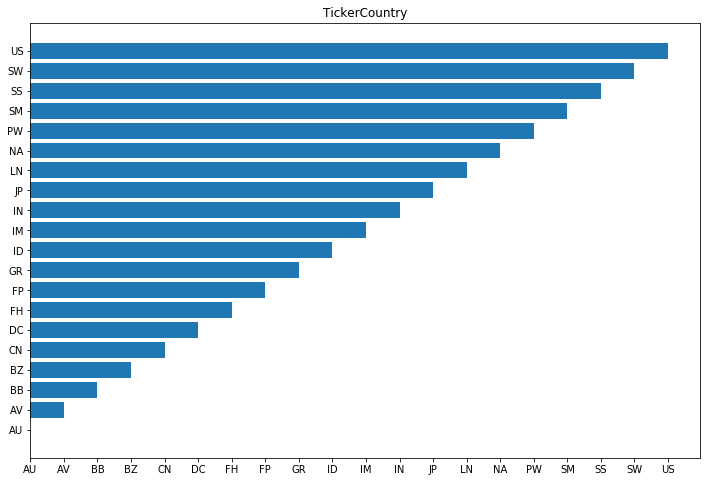

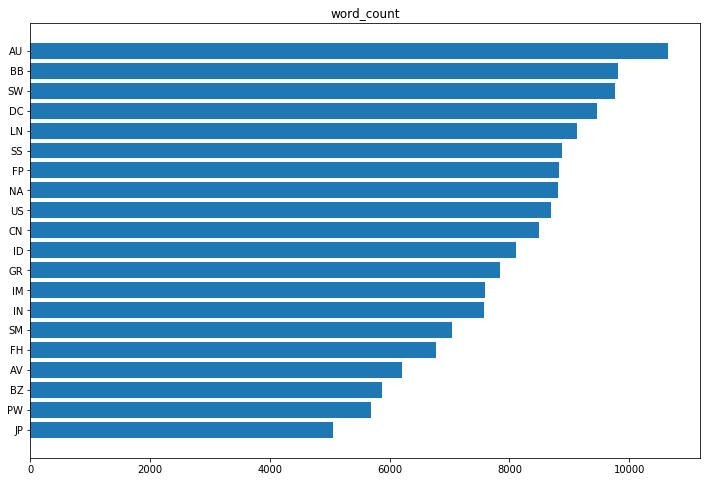

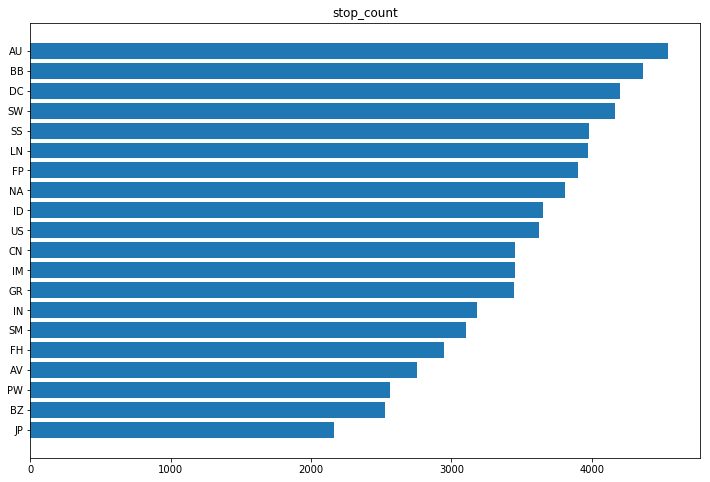

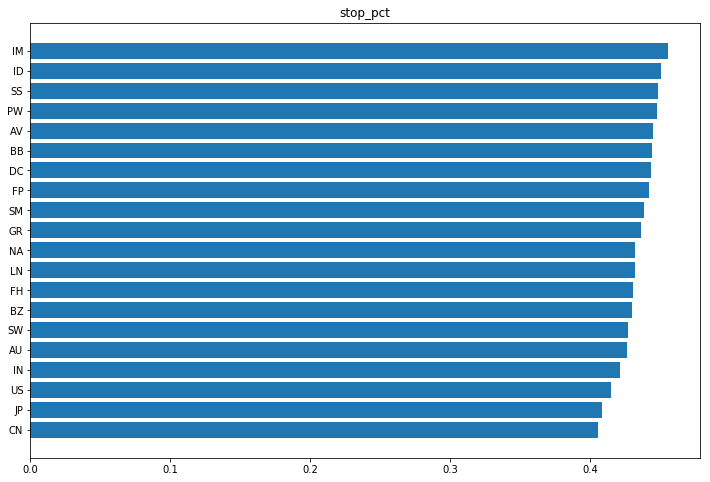

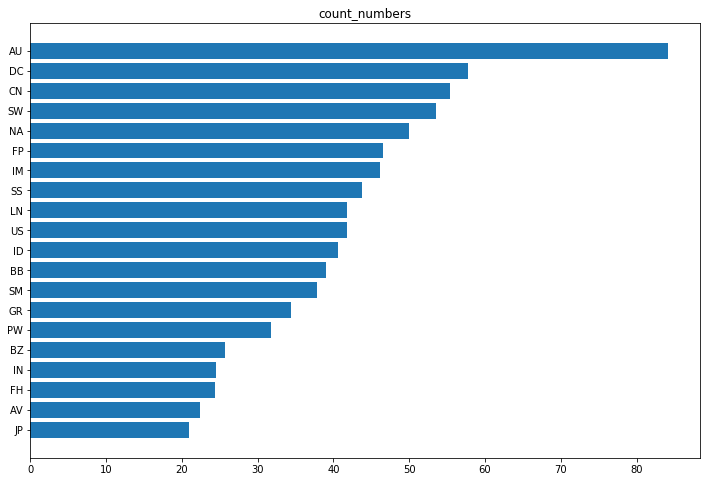

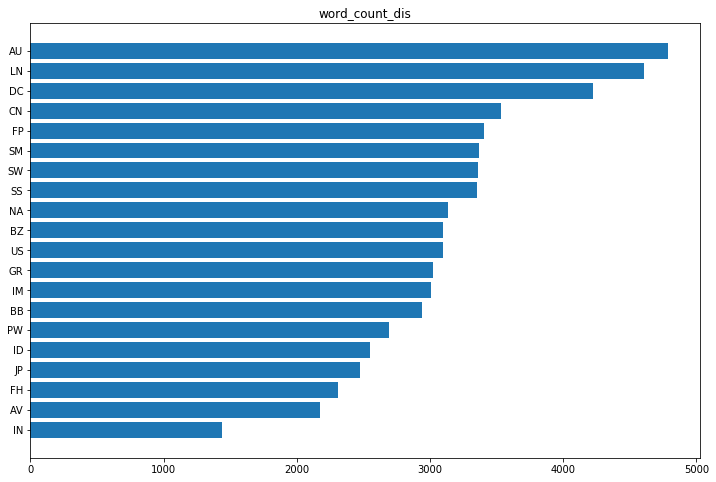

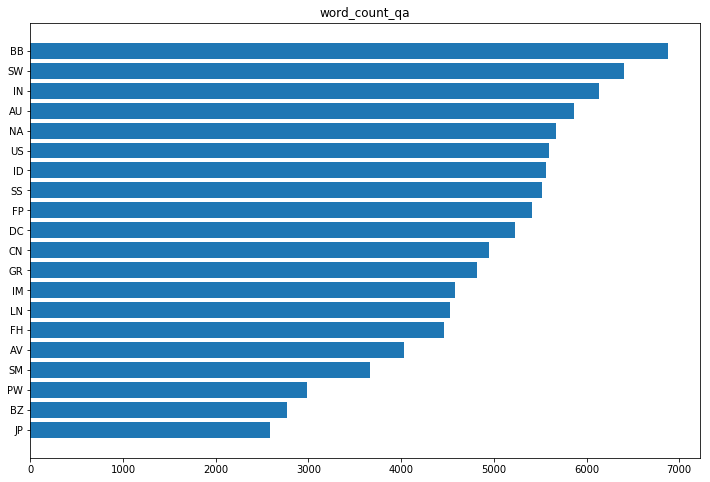

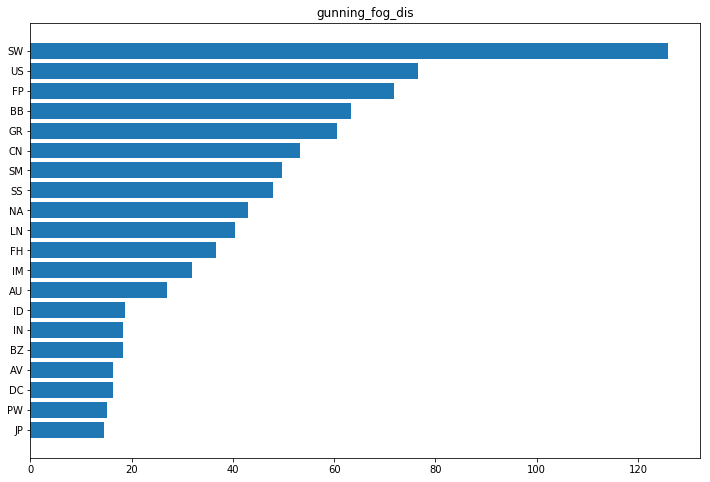

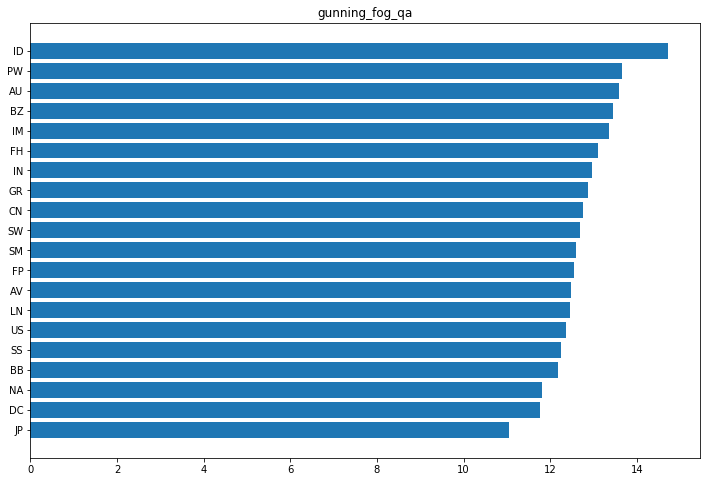

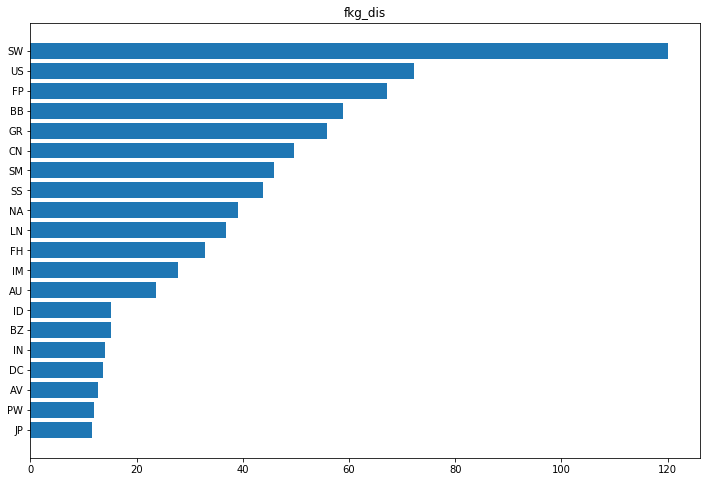

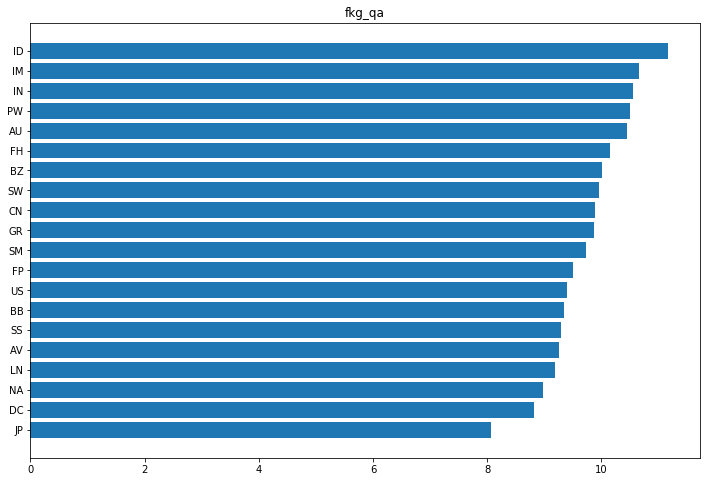

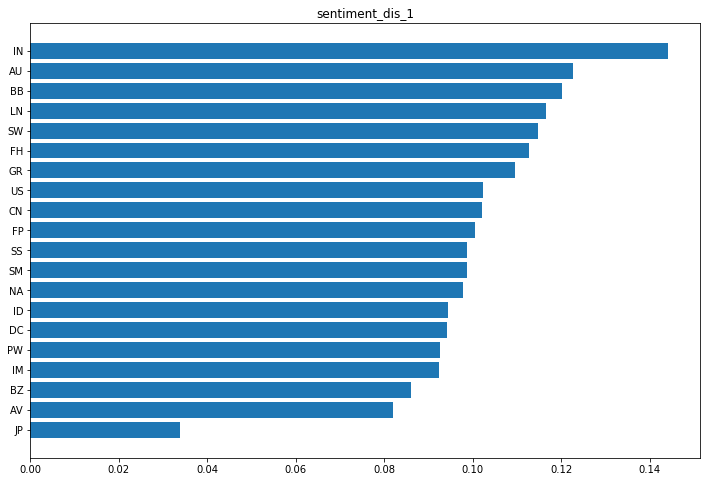

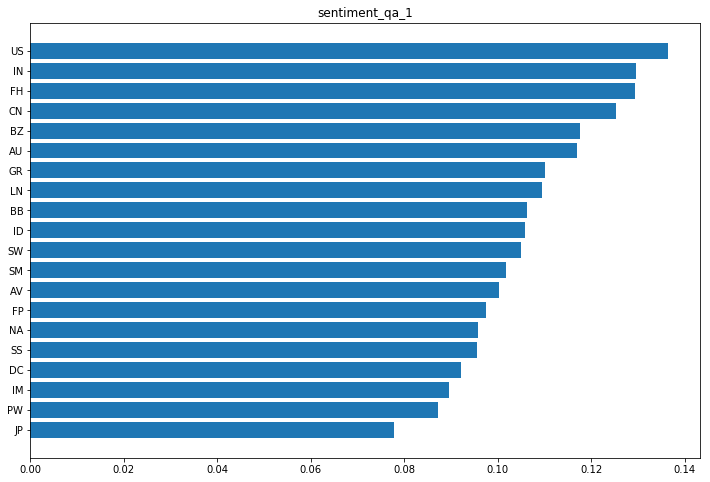

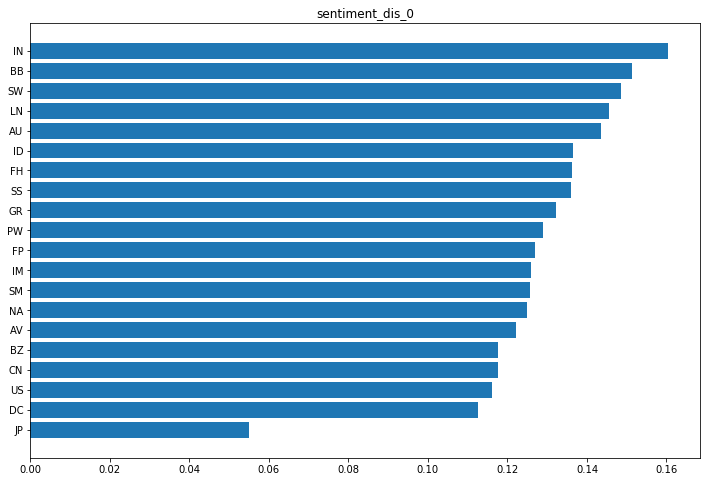

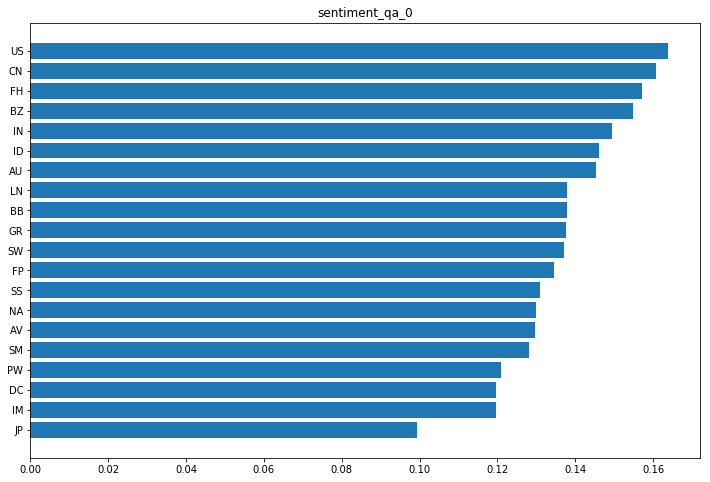

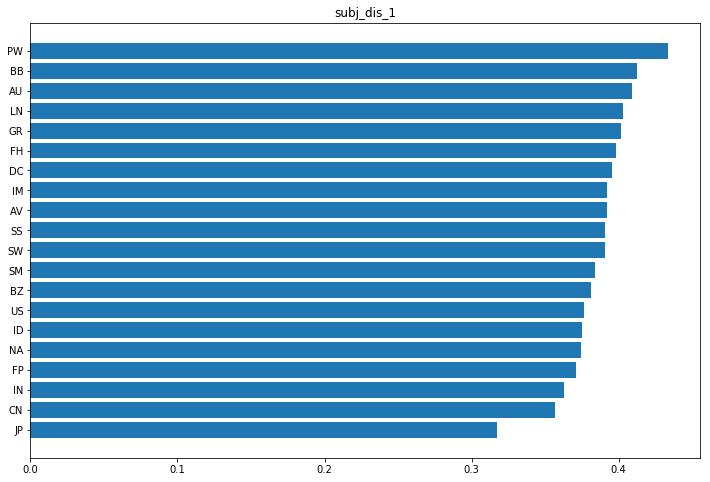

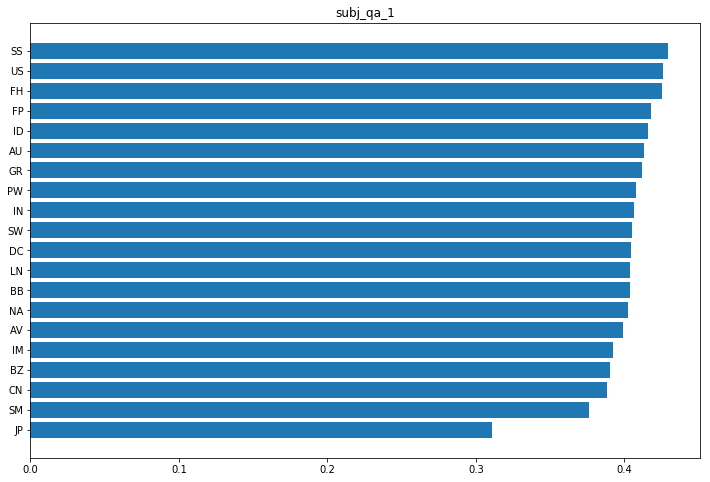

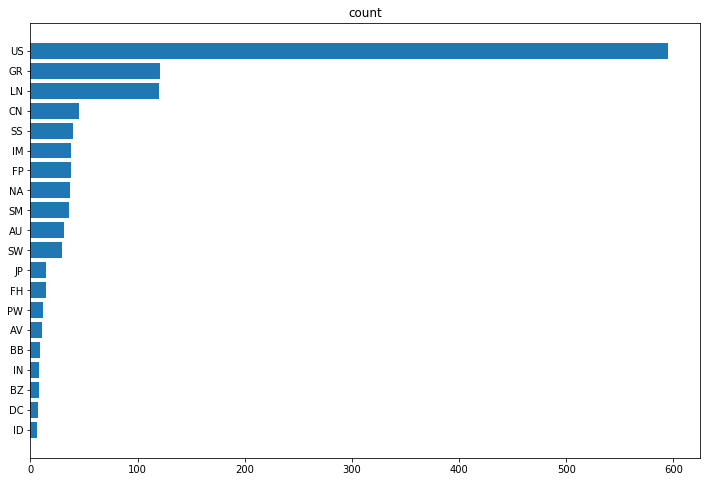

In [75]:
for col in ec_summary.columns:
    plt.figure(figsize = (12,8))
    temp = ec_summary.query('count > 5').sort_values(by=col)
    plt.barh(temp['TickerCountry'], temp[col])
    #ec_summary[['TickerCountry', 'gunning_fog_dis']].sort_values(by='gunning_fog_dis').plot(kind='bar')
    plt.title(col)
    plt.show()

In [79]:
ec_summary[['TickerCountry', 'gunning_fog_dis']].sort_index().plot.bar

<bound method FramePlotMethods.bar of <pandas.plotting._core.FramePlotMethods object at 0x000001990AAE4AC8>>

In [80]:
ec_summary.columns

Index(['TickerCountry', 'word_count', 'stop_count', 'stop_pct',
       'count_numbers', 'word_count_dis', 'word_count_qa', 'gunning_fog_dis',
       'gunning_fog_qa', 'fkg_dis', 'fkg_qa', 'sentiment_dis_1',
       'sentiment_qa_1', 'sentiment_dis_0', 'sentiment_qa_0', 'subj_dis_1',
       'subj_qa_1', 'count'],
      dtype='object')

In [81]:
import seaborn as sns

c:\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1233: RuntimeWarning: invalid value encountered in double_scalars
  loval = q1 - whis * stats['iqr']
c:\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1234: RuntimeWarning: invalid value encountered in double_scalars
  hival = q3 + whis * stats['iqr']
c:\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
c:\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)


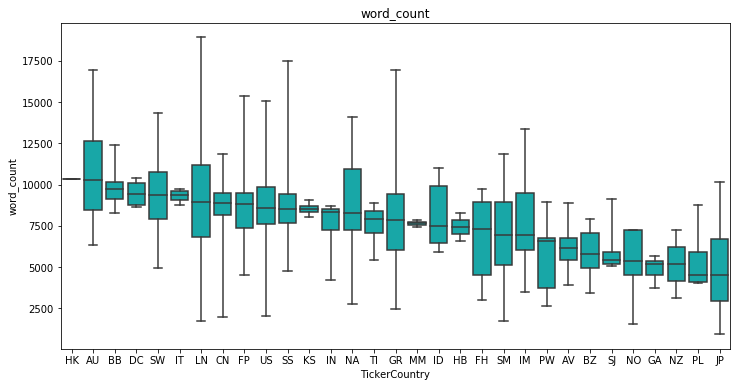

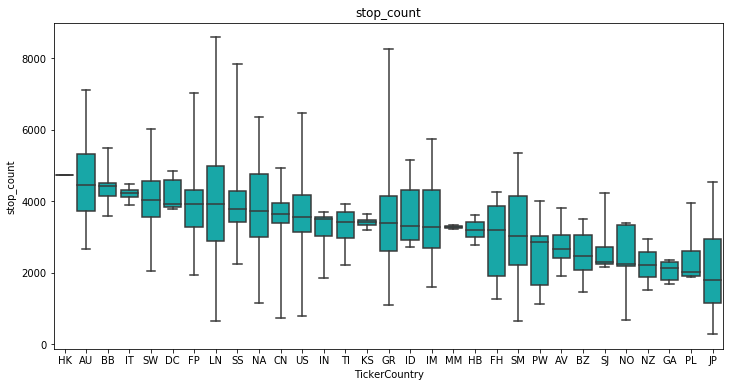

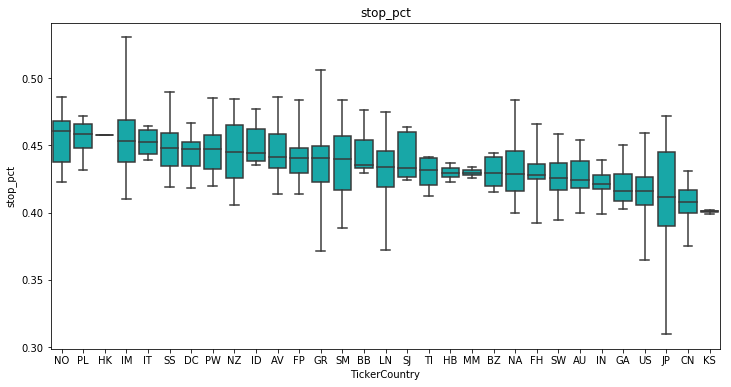

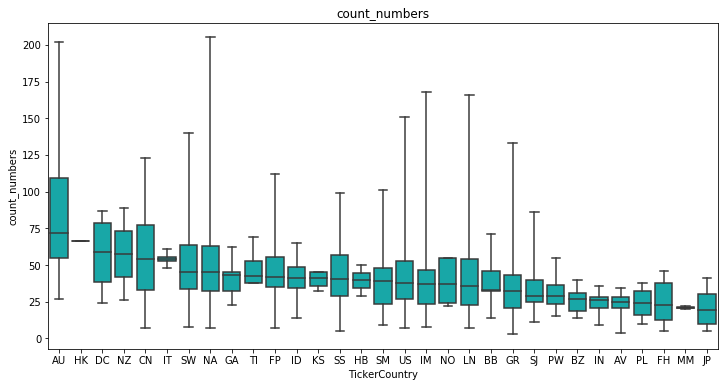

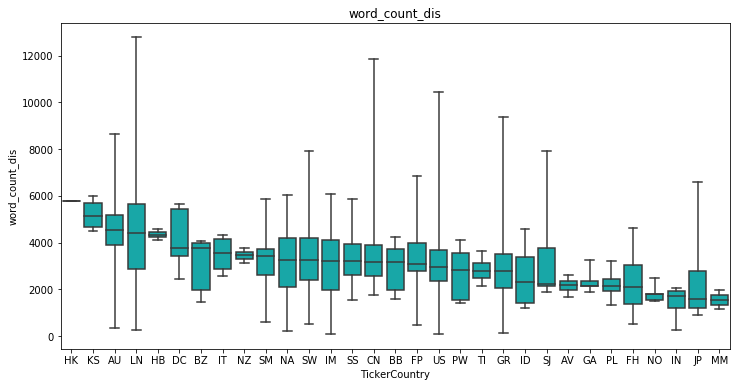

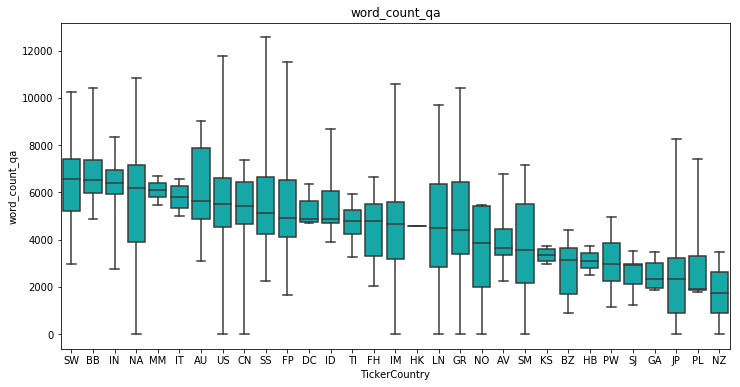

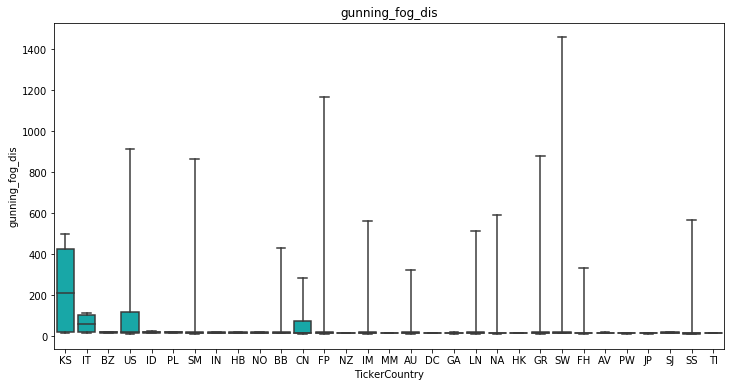

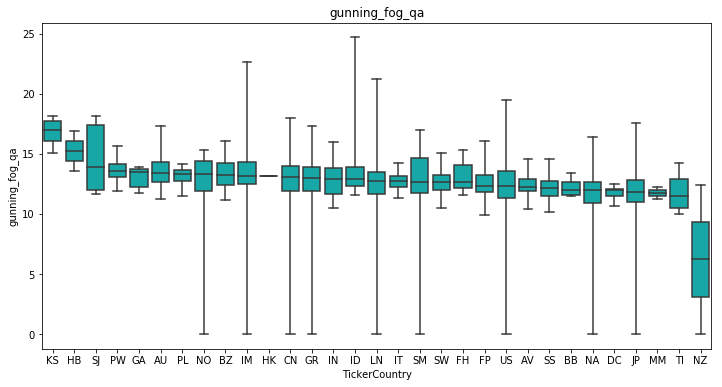

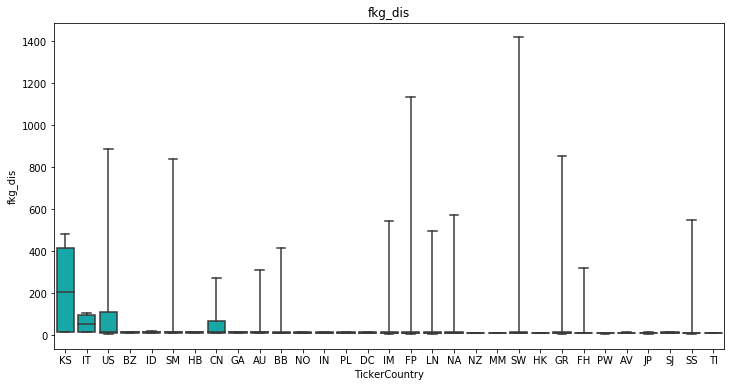

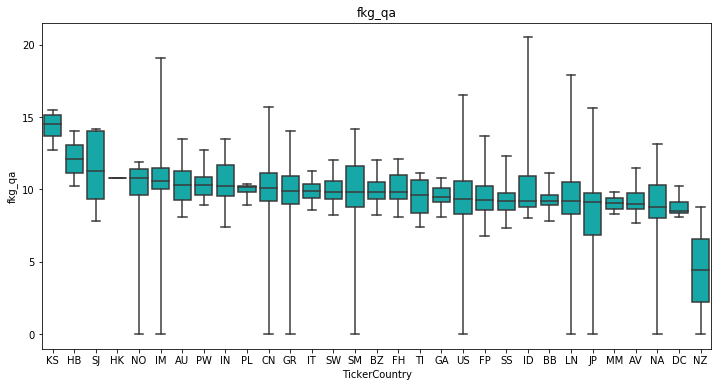

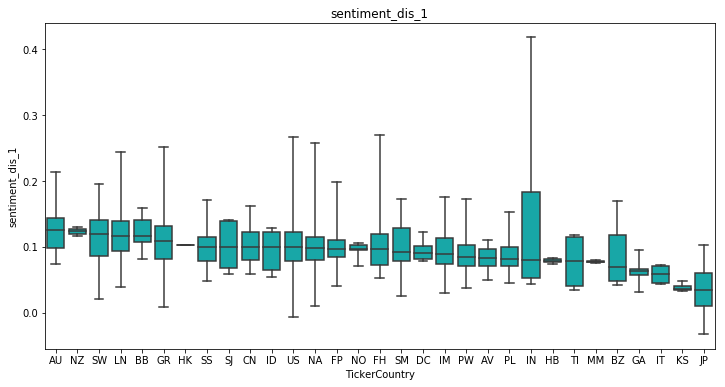

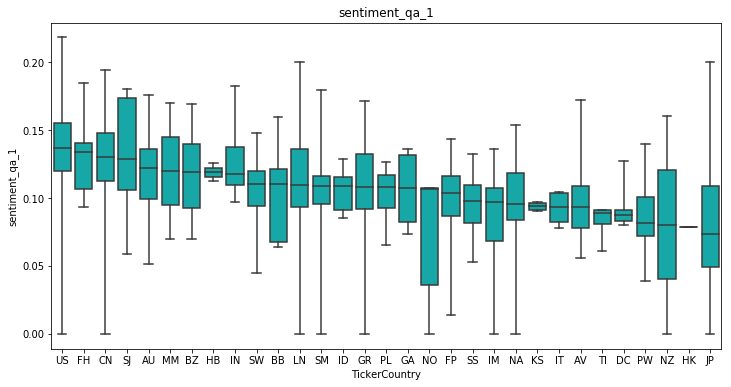

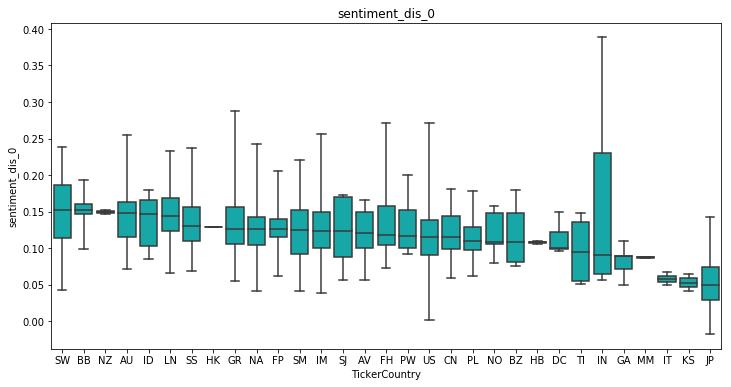

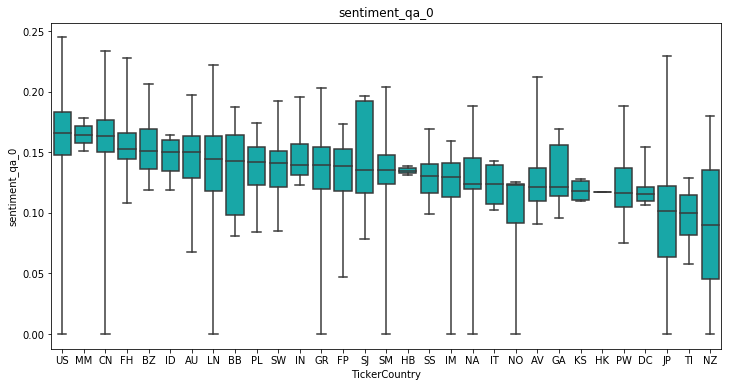

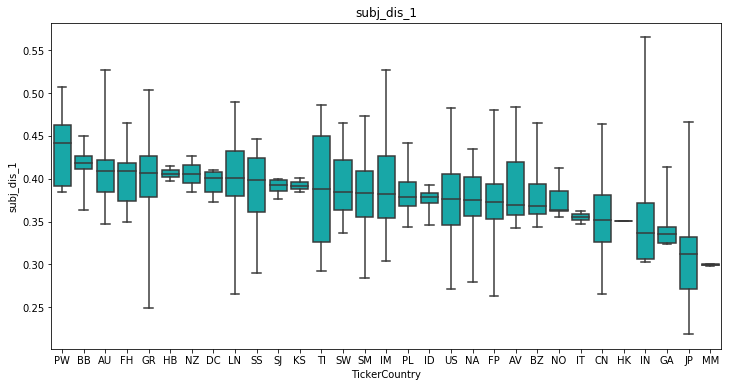

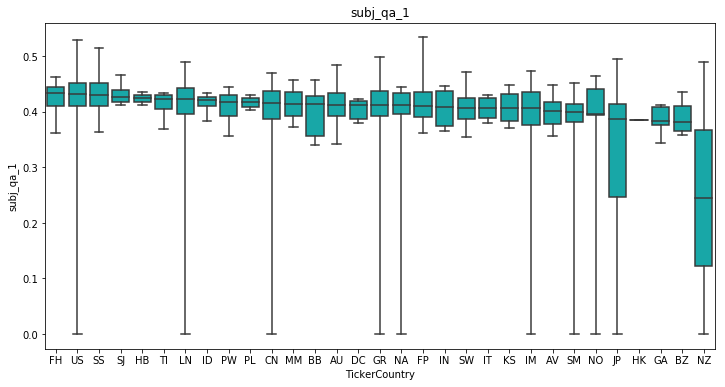

In [82]:
for col in ec_summary.columns[1:-1]:
    order = df_ec.groupby('TickerCountry')[col].median().sort_values()[::-1].index
    plt.figure(figsize=(12,6))
    sns.boxplot(x='TickerCountry', y=col, data=df_ec, whis=np.inf, color="c", order=order)
    plt.title(col)
    plt.show()

In [83]:
df_ec.groupby('count_companyParticipants')['TickerCountry', 'word_count', 'stop_count', 'stop_pct', 'count_numbers', 'word_count_dis', 'word_count_qa', 'gunning_fog_dis', 'gunning_fog_qa',
       'fkg_dis', 'fkg_qa', 'sentiment_dis_1', 'sentiment_qa_1',
       'sentiment_dis_0', 'sentiment_qa_0', 'subj_dis_1', 'subj_qa_1'].mean()

,word_count,stop_count,stop_pct,count_numbers,word_count_dis,word_count_qa,gunning_fog_dis,gunning_fog_qa,fkg_dis,fkg_qa,sentiment_dis_1,sentiment_qa_1,sentiment_dis_0,sentiment_qa_0,subj_dis_1,subj_qa_1
count_companyParticipants,,,,,,,,,,,,,,,,
1,6325.250000,2792.340909,0.438328,34.340909,2526.318182,3799.477273,44.080682,11.392955,39.856818,8.700000,0.097290,0.098100,0.126796,0.122433,0.382100,0.364351
2,7815.665399,3369.193916,0.428860,37.258555,3100.007605,4715.749049,73.295399,12.480913,68.671483,9.436882,0.099296,0.110891,0.123195,0.140359,0.380714,0.403069
3,8674.282609,3688.804348,0.424106,43.681159,3261.353261,5412.967391,64.303678,12.501377,60.149275,9.551630,0.102178,0.121509,0.121900,0.151570,0.382122,0.419655
4,8506.358289,3623.363636,0.425273,41.165775,3450.593583,5055.802139,42.702299,12.345775,39.006417,9.399465,0.109901,0.121976,0.129583,0.149621,0.390274,0.411217
5,8503.074074,3613.564815,0.423991,42.268519,3474.212963,5028.712963,68.270000,13.118333,63.869444,9.925000,0.105161,0.136529,0.122774,0.162271,0.385154,0.431619
6,9060.120000,3809.080000,0.419870,49.840000,3454.560000,5605.380000,50.965400,13.180200,47.016000,10.236000,0.104439,0.127303,0.120125,0.153715,0.376937,0.423535
7,10225.833333,4290.638889,0.417634,58.277778,3996.833333,6228.694444,65.813889,12.902500,61.661111,10.130556,0.102526,0.121267,0.122427,0.150190,0.377780,0.396105
8,10617.230769,4492.230769,0.422409,62.692308,4170.461538,6447.076923,44.263846,12.806154,40.461538,9.538462,0.116534,0.122416,0.140567,0.150427,0.400912,0.417576
9,9482.000000,4012.000000,0.423117,68.000000,4041.000000,5440.000000,16.420000,13.720000,14.500000,11.200000,0.118349,0.111426,0.153171,0.169834,0.340001,0.373467


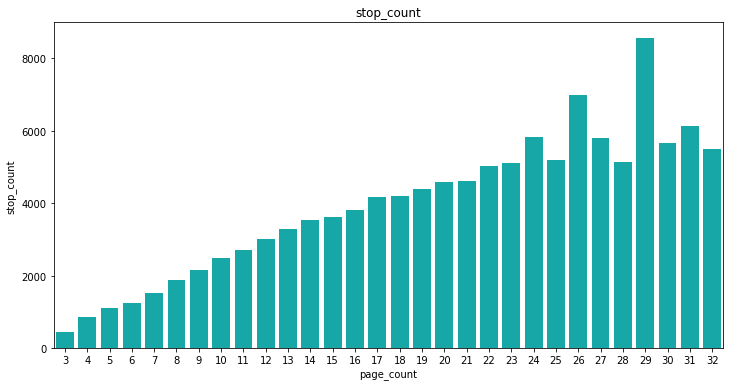

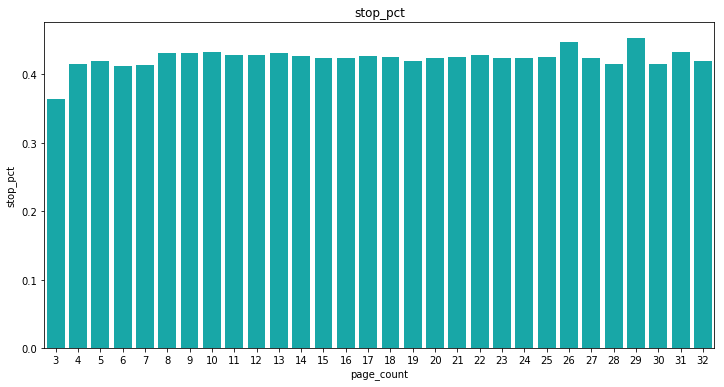

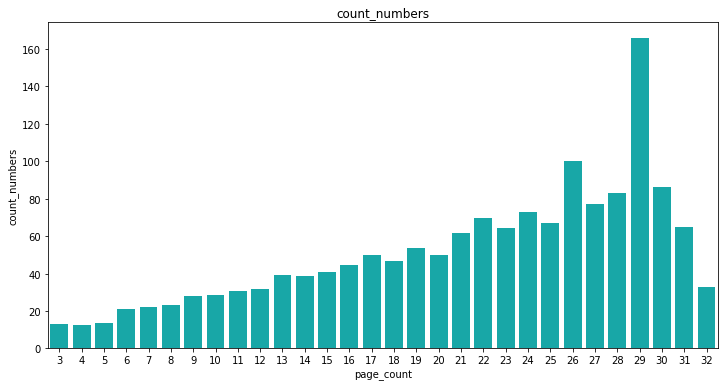

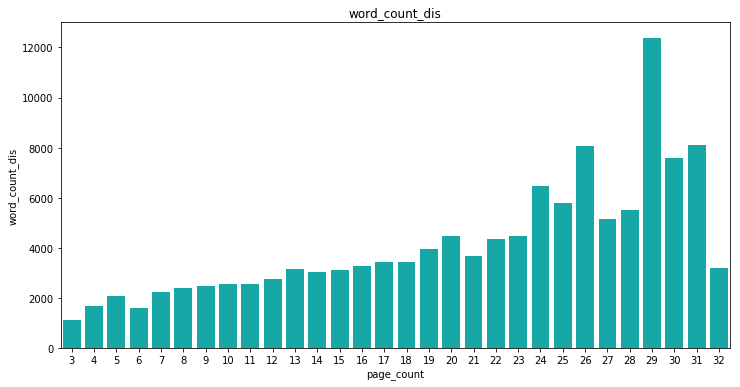

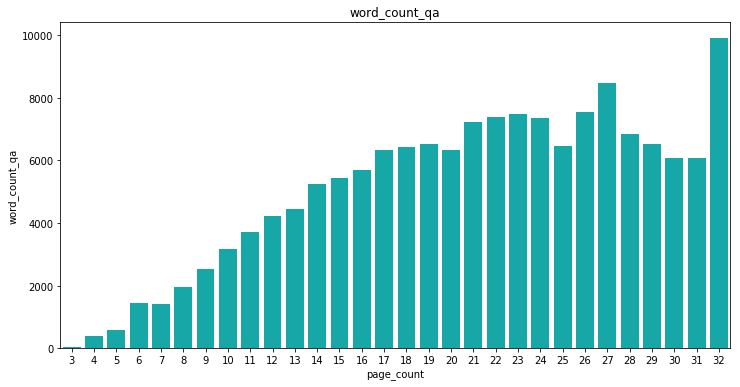

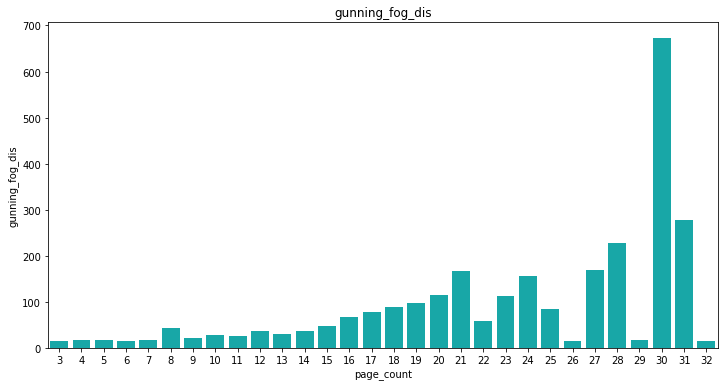

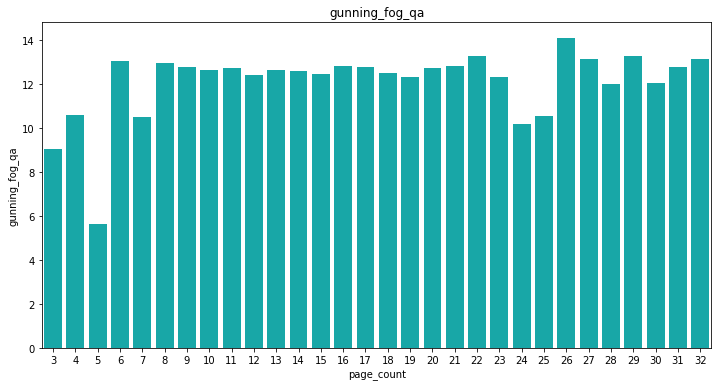

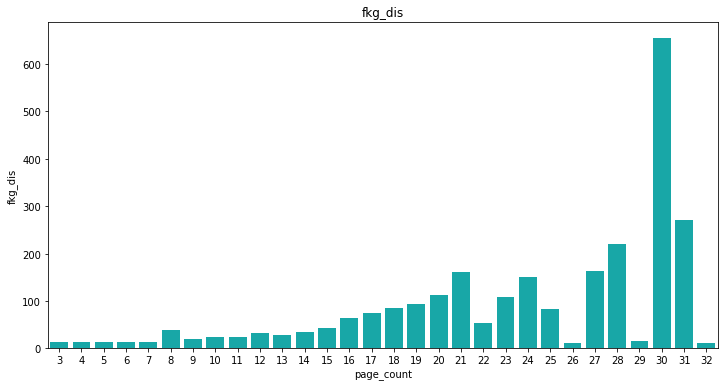

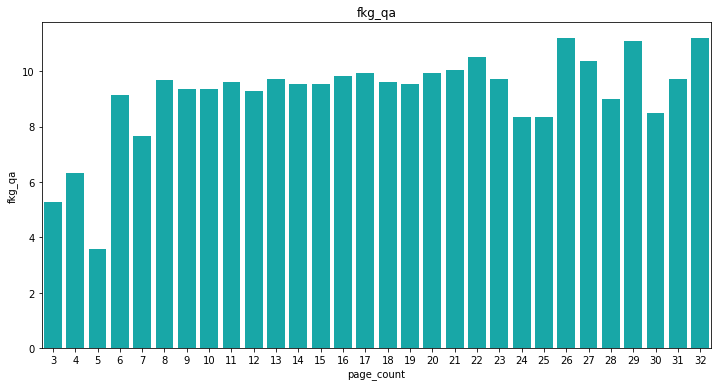

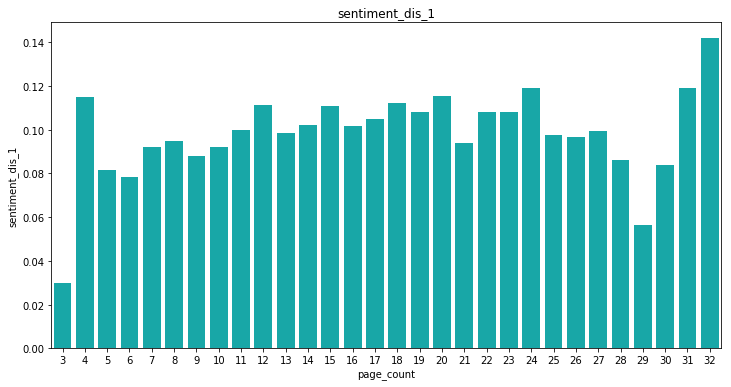

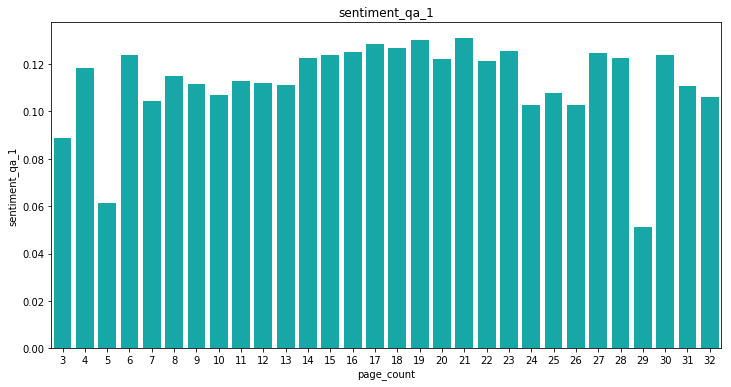

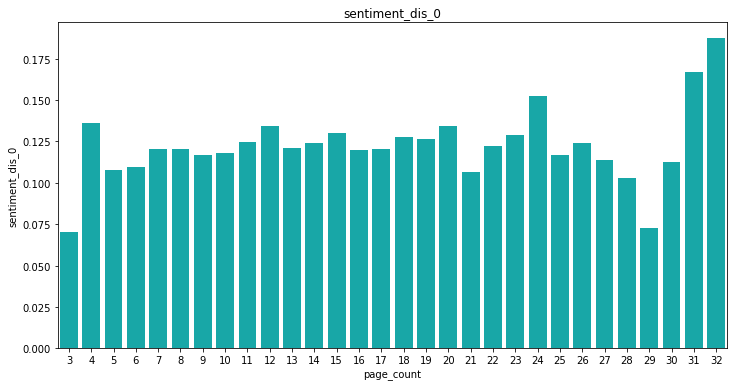

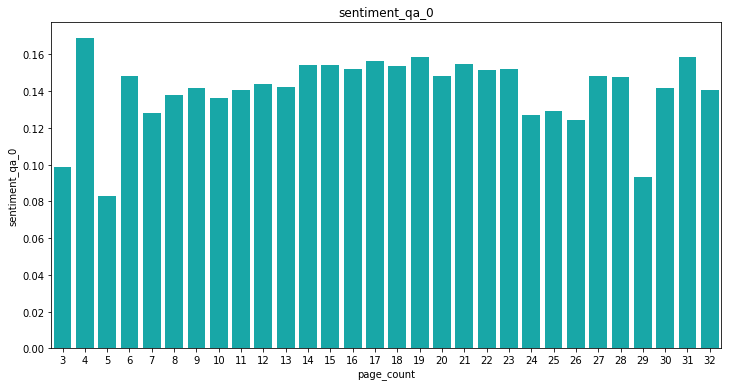

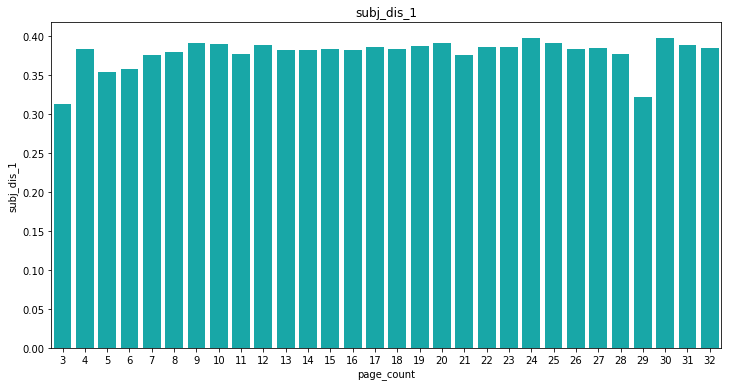

In [84]:
tmp = df_ec.groupby('page_count')['TickerCountry', 'word_count', 'stop_count', 'stop_pct', 'count_numbers', 'word_count_dis', 'word_count_qa', 'gunning_fog_dis', 'gunning_fog_qa',
       'fkg_dis', 'fkg_qa', 'sentiment_dis_1', 'sentiment_qa_1',
       'sentiment_dis_0', 'sentiment_qa_0', 'subj_dis_1', 'subj_qa_1'].mean()

for col in tmp.columns[1:-1]:
    #order = tmp.groupby('TickerCountry')[col].median().sort_values()[::-1].index
    plt.figure(figsize=(12,6))
    sns.barplot(x=tmp.index, y=col, data=tmp, color="c")
    plt.title(col)
    plt.show()

In [85]:
sns.sc

AttributeError: module 'seaborn' has no attribute 'sc'

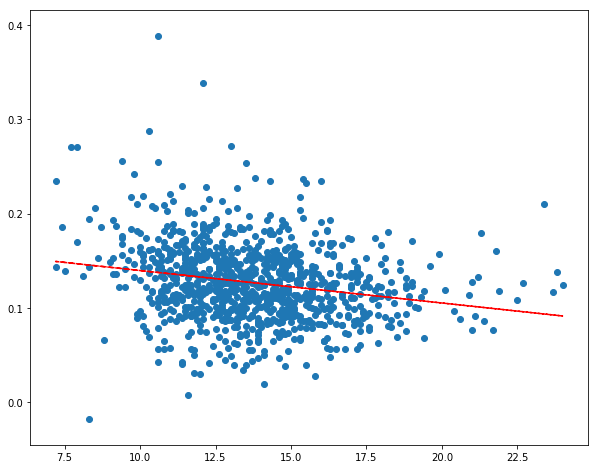

y=-0.003446x+(0.174023)


In [87]:
plt.figure(figsize=(10,8))
plt.scatter(x='fkg_dis', y='sentiment_dis_0', data=df_ec.query('fkg_dis < 25'))
z = np.polyfit(df_ec.query('fkg_dis < 25')['fkg_dis'], df_ec.query('fkg_dis < 25')['sentiment_dis_0'], 1)
p = np.poly1d(z)
plt.plot(df_ec.query('fkg_dis < 25')['fkg_dis'],p(df_ec.query('fkg_dis < 25')['fkg_dis']),"r--")
plt.show()
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

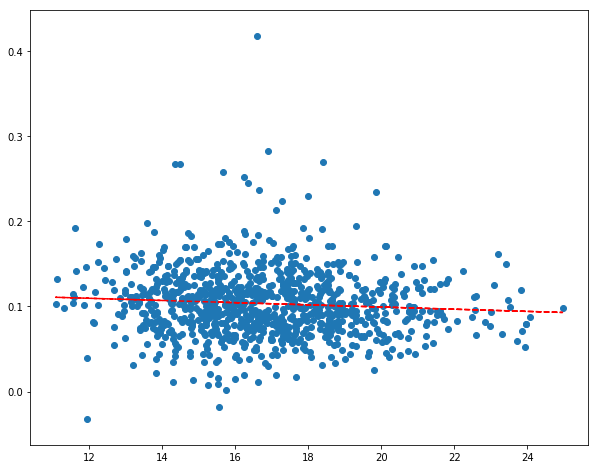

y=-0.001281x+(0.124934)


In [88]:
plt.figure(figsize=(10,8))
plt.scatter(x='gunning_fog_dis', y='sentiment_dis_1', data=df_ec.query('gunning_fog_dis < 25'))
z = np.polyfit(df_ec.query('gunning_fog_dis < 25')['gunning_fog_dis'], df_ec.query('gunning_fog_dis < 25')['sentiment_dis_1'], 1)
p = np.poly1d(z)
plt.plot(df_ec.query('gunning_fog_dis < 25')['gunning_fog_dis'],p(df_ec.query('gunning_fog_dis < 25')['gunning_fog_dis']),"r--")
plt.show()
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

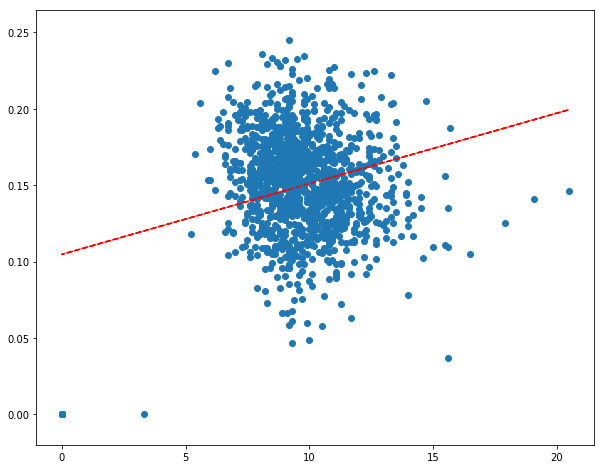

y=0.004616x+(0.104807)


In [89]:
plt.figure(figsize=(10,8))
plt.scatter(x='fkg_qa', y='sentiment_qa_0', data=df_ec.query('fkg_qa < 25'))
z = np.polyfit(df_ec.query('fkg_qa < 25')['fkg_qa'], df_ec.query('fkg_qa < 25')['sentiment_qa_0'], 1)
p = np.poly1d(z)
plt.plot(df_ec.query('fkg_qa < 25')['fkg_qa'],p(df_ec.query('fkg_qa < 25')['fkg_qa']),"r--")
plt.show()
print ("y=%.6fx+(%.6f)"%(z[0],z[1]))

c:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


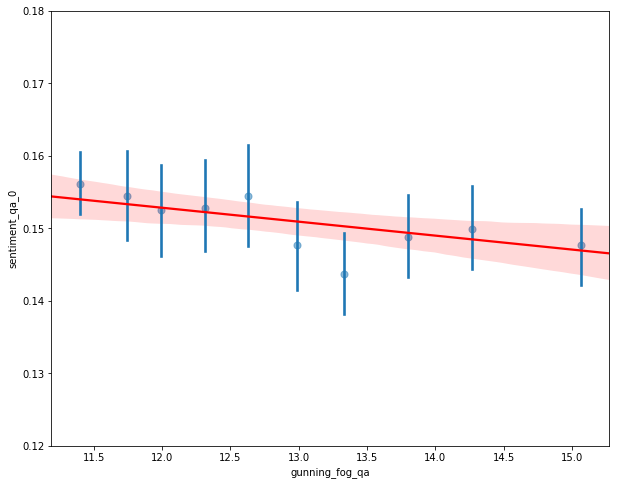

In [90]:
plt.figure(figsize=(10,8))
#plt.scatter(x='fkg_qa', y='sentiment_qa_0', data=df_ec.query('fkg_qa < 25'))
sns.regplot(x='gunning_fog_qa', y='sentiment_qa_0', data=df_ec.query('11 < gunning_fog_qa < 18'), 
            scatter_kws={'alpha': 0.5}, line_kws={'color':'red'},
            x_bins=10)
plt.ylim(0.12,0.18)
plt.show()

c:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


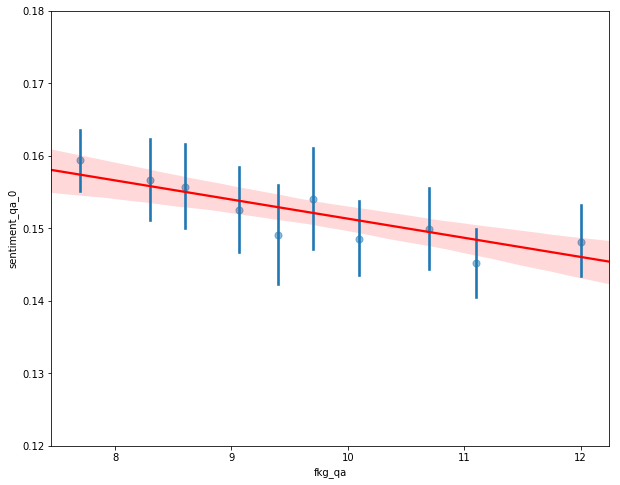

In [91]:
plt.figure(figsize=(10,8))
#plt.scatter(x='fkg_qa', y='sentiment_qa_0', data=df_ec.query('fkg_qa < 25'))
sns.regplot(x='fkg_qa', y='sentiment_qa_0', data=df_ec.query('5 < fkg_qa < 18'), 
            scatter_kws={'alpha': 0.5}, line_kws={'color':'red'},
            truncate=True,
            x_bins=10)
plt.ylim(0.12,0.18)
plt.show()

c:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


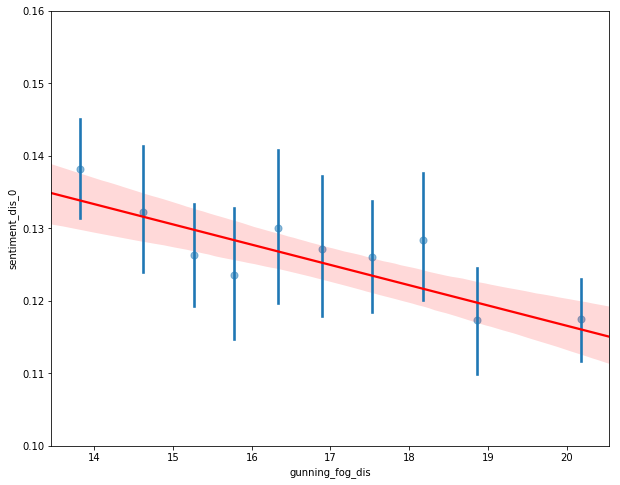

In [92]:
plt.figure(figsize=(10,8))
#plt.scatter(x='fkg_qa', y='sentiment_qa_0', data=df_ec.query('fkg_qa < 25'))
sns.regplot(x='gunning_fog_dis', y='sentiment_dis_0', data=df_ec.query('11 < gunning_fog_dis < 25'), 
            scatter_kws={'alpha': 0.5}, line_kws={'color':'red'},
            robust=True,
            x_bins=10)
plt.ylim(0.1,0.16)
plt.show()

In [93]:
ec_summary.columns

Index(['TickerCountry', 'word_count', 'stop_count', 'stop_pct',
       'count_numbers', 'word_count_dis', 'word_count_qa', 'gunning_fog_dis',
       'gunning_fog_qa', 'fkg_dis', 'fkg_qa', 'sentiment_dis_1',
       'sentiment_qa_1', 'sentiment_dis_0', 'sentiment_qa_0', 'subj_dis_1',
       'subj_qa_1', 'count'],
      dtype='object')

## Putting it Together

In [ ]:
df_ec.columns

In [94]:
df_ec['call_date'] = pd.to_datetime(df_ec['call_date'], format='%Y-%m-%d')
df_ec.shape

(1260, 37)

In [95]:
df_input = df_ec.merge(df_spreads2, how='left', left_on=['company_ticker', 'call_date'], right_on=['EquityTicker', 'Date']).drop(['EquityTicker', 'TickerCountry_y'], axis=1)
df_input.shape

(9382, 46)

In [96]:
tmp = df_spreads2.copy()
tmp['Date_y'] = tmp['Date'] - timedelta(days=7)

df_input.merge(tmp[['EquityTicker','ISIN','CorpID', 'Date', 'Date_y', 'Spread']], 
               how='left', 
               left_on=['company_ticker','CorpID','ISIN', 'Date'], 
               right_on=['EquityTicker','CorpID','ISIN', 'Date_y'],
               suffixes = ('','_p7')
              ).drop('Date_y', axis=1).shape

(9382, 49)

In [97]:
df_input2 = df_input.copy()
tmp = df_spreads2.copy()
for i in range(1,13):
    s = 'after_spreadw'+ str(i)
    d = 'after_datew' + str(i)
    tmp[s] = tmp['Spread']
    tmp[d] = tmp['Date']
    tmp['Date_y'] = tmp['Date'] - timedelta(days=7*i)
    df_input2 = df_input2.merge(tmp[['EquityTicker','ISIN','CorpID', 'Date_y', d, s]], 
                               how='left', 
                               left_on=['company_ticker','CorpID','ISIN', 'Date'], 
                               right_on=['EquityTicker','CorpID','ISIN', 'Date_y'],
                              ).drop([d, 'Date_y', 'EquityTicker'], axis=1)
    print(s)

after_spreadw1
after_spreadw2
after_spreadw3
after_spreadw4
after_spreadw5
after_spreadw6
after_spreadw7
after_spreadw8
after_spreadw9
after_spreadw10
after_spreadw11
after_spreadw12


In [98]:
df_input2.shape

(9382, 58)

In [99]:
df_input2.head()

,index,call_date,title,company_name,companyParticipants,file_name,YTDchangePct,company_ticker,market_cap,currentPX,...,after_spreadw3,after_spreadw4,after_spreadw5,after_spreadw6,after_spreadw7,after_spreadw8,after_spreadw9,after_spreadw10,after_spreadw11,after_spreadw12
0,20170802_8303_EarningsCall_FS00000000236932122...,2017-08-02,Q1 2017 Earnings Call - Q&A,Shinsei Bank,"[Hiroshi Ishii, Sanjeev Gupta]",20170802_8303_EarningsCall_FS00000000236932122...,-10.714,8303 JP,"481,310.71",175,...,269.499,269.499,269.499,269.499,269.499,269.499,269.499,269.499,269.499,269.499
1,20170802_AKE_EarningsCall_FS000000002368092514...,2017-08-02,Q2 2017 Earnings Call,Arkema,"[Thierry le Hénaff, Thierry Lemonnier]",20170802_AKE_EarningsCall_FS000000002368092514...,+2.690,AKE FP,"7,231.86",95.44,...,195.703,199.268,207.854,199.761,188.409,187.426,183.177,174.779,168.779,162.972
2,20170802_AKE_EarningsCall_FS000000002368092514...,2017-08-02,Q2 2017 Earnings Call,Arkema,"[Thierry le Hénaff, Thierry Lemonnier]",20170802_AKE_EarningsCall_FS000000002368092514...,+2.690,AKE FP,"7,231.86",95.44,...,-1.657,6.356,6.749,9.977,10.736,8.217,9.205,7.626,5.972,5.976
3,20170802_AKE_EarningsCall_FS000000002368092514...,2017-08-02,Q2 2017 Earnings Call,Arkema,"[Thierry le Hénaff, Thierry Lemonnier]",20170802_AKE_EarningsCall_FS000000002368092514...,+2.690,AKE FP,"7,231.86",95.44,...,42.315,53.250,55.012,54.027,48.583,45.084,43.576,41.966,40.030,39.045
4,20170802_AKE_EarningsCall_FS000000002368092514...,2017-08-02,Q2 2017 Earnings Call,Arkema,"[Thierry le Hénaff, Thierry Lemonnier]",20170802_AKE_EarningsCall_FS000000002368092514...,+2.690,AKE FP,"7,231.86",95.44,...,53.666,62.924,63.457,63.552,58.662,54.685,53.342,51.939,49.390,48.451


In [100]:
#df_input2 = df_input.copy()
tmp = df_spreads2.copy()
for i in range(1,13):
    s = 'before_spreadw'+ str(i)
    d = 'before_datew' + str(i)
    tmp[s] = tmp['Spread']
    tmp[d] = tmp['Date']
    tmp['Date_y'] = tmp['Date'] + timedelta(days=7*i)
    df_input2 = df_input2.merge(tmp[['EquityTicker','ISIN','CorpID', 'Date_y', d, s]], 
                               how='left', 
                               left_on=['company_ticker','CorpID','ISIN', 'Date'], 
                               right_on=['EquityTicker','CorpID','ISIN', 'Date_y'],
                              ).drop([d, 'Date_y', 'EquityTicker'], axis=1)
    print(s)

before_spreadw1
before_spreadw2
before_spreadw3
before_spreadw4
before_spreadw5
before_spreadw6
before_spreadw7
before_spreadw8
before_spreadw9
before_spreadw10
before_spreadw11
before_spreadw12


In [101]:
df_input2.tail()

,index,call_date,title,company_name,companyParticipants,file_name,YTDchangePct,company_ticker,market_cap,currentPX,...,before_spreadw3,before_spreadw4,before_spreadw5,before_spreadw6,before_spreadw7,before_spreadw8,before_spreadw9,before_spreadw10,before_spreadw11,before_spreadw12
9377,20180131_VOLVB_EarningsCall_FS0000000023958826...,2018-01-31,Q4 2017 Earnings Call,Volvo,"[Joakim Kenndal, Martin Lundstedt, Jan Gurander]",20180131_VOLVB_EarningsCall_FS0000000023958826...,+5.337,VOLVB SS,"343,052.36",160.85,...,94.863,106.876,114.797,118.452,127.585,128.700,128.070,135.712,146.714,123.584
9378,20180131_VOLVB_EarningsCall_FS0000000023958826...,2018-01-31,Q4 2017 Earnings Call,Volvo,"[Joakim Kenndal, Martin Lundstedt, Jan Gurander]",20180131_VOLVB_EarningsCall_FS0000000023958826...,+5.337,VOLVB SS,"343,052.36",160.85,...,156.213,160.537,163.223,166.089,174.287,174.650,169.835,173.561,178.769,164.629
9379,20180131_VOLVB_EarningsCall_FS0000000023958826...,2018-01-31,Q4 2017 Earnings Call,Volvo,"[Joakim Kenndal, Martin Lundstedt, Jan Gurander]",20180131_VOLVB_EarningsCall_FS0000000023958826...,+5.337,VOLVB SS,"343,052.36",160.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9380,20180131_VOLVB_EarningsCall_FS0000000023958826...,2018-01-31,Q4 2017 Earnings Call,Volvo,"[Joakim Kenndal, Martin Lundstedt, Jan Gurander]",20180131_VOLVB_EarningsCall_FS0000000023958826...,+5.337,VOLVB SS,"343,052.36",160.85,...,16.699,11.825,9.385,7.135,7.015,7.077,10.826,11.135,8.209,5.207
9381,20180131_VOLVB_EarningsCall_FS0000000023958826...,2018-01-31,Q4 2017 Earnings Call,Volvo,"[Joakim Kenndal, Martin Lundstedt, Jan Gurander]",20180131_VOLVB_EarningsCall_FS0000000023958826...,+5.337,VOLVB SS,"343,052.36",160.85,...,-76.700,-76.700,-76.700,-76.700,-76.700,-76.700,-76.700,-76.700,-76.700,-76.700


## Calculate Spread Changes

In [102]:
df_input2.columns

Index(['index', 'call_date', 'title', 'company_name', 'companyParticipants',
       'file_name', 'YTDchangePct', 'company_ticker', 'market_cap',
       'currentPX', 'page_count', 'text', 'YTDchangeVal', 'otherParticipants',
       'count_companyParticipants', 'count_otherParticipants',
       'TickerCountry_x', 'word_count', 'stop_count', 'stop_pct',
       'count_numbers', 'text_discussion', 'text_qa', 'word_count_dis',
       'word_count_qa', 'text_dis_clean', 'text_qa_clean', 'gunning_fog_dis',
       'gunning_fog_qa', 'fkg_dis', 'fkg_qa', 'sentiment_dis_1',
       'sentiment_qa_1', 'sentiment_dis_0', 'sentiment_qa_0', 'subj_dis_1',
       'subj_qa_1', 'BondTicker', 'CorpID', 'ISIN', 'Date', 'Spread', 'Year',
       'Quarter', 'Month', 'Weekday', 'after_spreadw1', 'after_spreadw2',
       'after_spreadw3', 'after_spreadw4', 'after_spreadw5', 'after_spreadw6',
       'after_spreadw7', 'after_spreadw8', 'after_spreadw9', 'after_spreadw10',
       'after_spreadw11', 'after_spreadw12', 

In [103]:
for i in range(1,13):
    df_input2['after_sprd_chg' + str(i)] = np.log(df_input2['after_spreadw' + str(i)]) - np.log(df_input2['Spread'])

df_input2.head()

c:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


,index,call_date,title,company_name,companyParticipants,file_name,YTDchangePct,company_ticker,market_cap,currentPX,...,after_sprd_chg3,after_sprd_chg4,after_sprd_chg5,after_sprd_chg6,after_sprd_chg7,after_sprd_chg8,after_sprd_chg9,after_sprd_chg10,after_sprd_chg11,after_sprd_chg12
0,20170802_8303_EarningsCall_FS00000000236932122...,2017-08-02,Q1 2017 Earnings Call - Q&A,Shinsei Bank,"[Hiroshi Ishii, Sanjeev Gupta]",20170802_8303_EarningsCall_FS00000000236932122...,-10.714,8303 JP,"481,310.71",175,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,20170802_AKE_EarningsCall_FS000000002368092514...,2017-08-02,Q2 2017 Earnings Call,Arkema,"[Thierry le Hénaff, Thierry Lemonnier]",20170802_AKE_EarningsCall_FS000000002368092514...,+2.690,AKE FP,"7,231.86",95.44,...,0.028685,0.046738,0.088923,0.049209,-0.009298,-0.014529,-0.037460,-0.084391,-0.119323,-0.154335
2,20170802_AKE_EarningsCall_FS000000002368092514...,2017-08-02,Q2 2017 Earnings Call,Arkema,"[Thierry le Hénaff, Thierry Lemonnier]",20170802_AKE_EarningsCall_FS000000002368092514...,+2.690,AKE FP,"7,231.86",95.44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20170802_AKE_EarningsCall_FS000000002368092514...,2017-08-02,Q2 2017 Earnings Call,Arkema,"[Thierry le Hénaff, Thierry Lemonnier]",20170802_AKE_EarningsCall_FS000000002368092514...,+2.690,AKE FP,"7,231.86",95.44,...,0.088062,0.317919,0.350472,0.332405,0.226195,0.151448,0.117427,0.079781,0.032550,0.007636
4,20170802_AKE_EarningsCall_FS000000002368092514...,2017-08-02,Q2 2017 Earnings Call,Arkema,"[Thierry le Hénaff, Thierry Lemonnier]",20170802_AKE_EarningsCall_FS000000002368092514...,+2.690,AKE FP,"7,231.86",95.44,...,0.077036,0.236184,0.244619,0.246115,0.166049,0.095846,0.070981,0.044327,-0.005995,-0.025190


In [104]:
df_input2.columns

Index(['index', 'call_date', 'title', 'company_name', 'companyParticipants',
       'file_name', 'YTDchangePct', 'company_ticker', 'market_cap',
       'currentPX', 'page_count', 'text', 'YTDchangeVal', 'otherParticipants',
       'count_companyParticipants', 'count_otherParticipants',
       'TickerCountry_x', 'word_count', 'stop_count', 'stop_pct',
       'count_numbers', 'text_discussion', 'text_qa', 'word_count_dis',
       'word_count_qa', 'text_dis_clean', 'text_qa_clean', 'gunning_fog_dis',
       'gunning_fog_qa', 'fkg_dis', 'fkg_qa', 'sentiment_dis_1',
       'sentiment_qa_1', 'sentiment_dis_0', 'sentiment_qa_0', 'subj_dis_1',
       'subj_qa_1', 'BondTicker', 'CorpID', 'ISIN', 'Date', 'Spread', 'Year',
       'Quarter', 'Month', 'Weekday', 'after_spreadw1', 'after_spreadw2',
       'after_spreadw3', 'after_spreadw4', 'after_spreadw5', 'after_spreadw6',
       'after_spreadw7', 'after_spreadw8', 'after_spreadw9', 'after_spreadw10',
       'after_spreadw11', 'after_spreadw12', 

In [105]:
nan = np.nan
df_cor = df_input2[['otherParticipants',
       'count_companyParticipants', 'count_otherParticipants',
       'TickerCountry_x', 'stop_pct',
       'count_numbers', 'word_count_dis',
       'word_count_qa', 'gunning_fog_dis',
       'gunning_fog_qa', 'fkg_dis', 'fkg_qa', 'sentiment_dis_1',
       'sentiment_qa_1', 'sentiment_dis_0', 'sentiment_qa_0', 'subj_dis_1',
       'subj_qa_1', 'after_sprd_chg1',
       'after_sprd_chg2', 'after_sprd_chg3', 'after_sprd_chg4',
       'after_sprd_chg5', 'after_sprd_chg6', 'after_sprd_chg7',
       'after_sprd_chg8', 'after_sprd_chg9', 'after_sprd_chg10',
       'after_sprd_chg11', 'after_sprd_chg12']].query('after_sprd_chg8 != 0 or after_sprd_chg8 != @nan').corr()
df_cor

,count_companyParticipants,count_otherParticipants,stop_pct,count_numbers,word_count_dis,word_count_qa,gunning_fog_dis,gunning_fog_qa,fkg_dis,fkg_qa,...,after_sprd_chg3,after_sprd_chg4,after_sprd_chg5,after_sprd_chg6,after_sprd_chg7,after_sprd_chg8,after_sprd_chg9,after_sprd_chg10,after_sprd_chg11,after_sprd_chg12
count_companyParticipants,1.000000,-0.020044,0.027441,0.119623,0.159321,0.044447,-0.140595,0.126058,-0.140423,0.099636,...,0.034528,0.048841,0.044544,0.029658,0.008725,0.008299,-0.003137,-0.002598,-0.011113,-0.025431
count_otherParticipants,-0.020044,1.000000,-0.128837,0.113688,-0.141265,0.740152,0.132622,-0.107754,0.132108,-0.037757,...,-0.083231,-0.050464,-0.074509,-0.094426,-0.043650,-0.011660,0.030942,0.060316,0.068930,0.021478
stop_pct,0.027441,-0.128837,1.000000,-0.062962,0.157671,0.072647,-0.126904,0.258760,-0.127564,0.306513,...,0.012552,0.018040,0.033446,0.033305,0.007265,0.005760,-0.020824,-0.025621,-0.046450,-0.007643
count_numbers,0.119623,0.113688,-0.062962,1.000000,0.569786,0.224007,0.025580,0.039275,0.027708,0.045450,...,0.044308,0.035905,0.020291,0.044864,0.080789,0.101639,0.094044,0.092916,0.083090,0.097843
word_count_dis,0.159321,-0.141265,0.157671,0.569786,1.000000,-0.092263,0.090179,-0.097214,0.093443,-0.101038,...,0.024437,-0.006543,-0.008363,0.002022,0.032605,0.030404,0.015462,0.001753,0.000660,0.030548
word_count_qa,0.044447,0.740152,0.072647,0.224007,-0.092263,1.000000,0.029442,0.082405,0.029139,0.156899,...,-0.047991,-0.003267,-0.017148,-0.035854,-0.009144,0.003820,0.039390,0.057923,0.055208,0.038129
gunning_fog_dis,-0.140595,0.132622,-0.126904,0.025580,0.090179,0.029442,1.000000,0.073016,0.999984,0.046306,...,-0.034920,-0.028494,-0.030187,-0.046113,-0.015275,-0.011326,0.006865,0.023164,0.033226,0.015708
gunning_fog_qa,0.126058,-0.107754,0.258760,0.039275,-0.097214,0.082405,0.073016,1.000000,0.072919,0.948768,...,0.035685,0.040567,0.053590,0.051044,0.017774,0.001900,-0.016606,-0.027831,-0.023429,-0.017677
fkg_dis,-0.140423,0.132108,-0.127564,0.027708,0.093443,0.029139,0.999984,0.072919,1.000000,0.046407,...,-0.034926,-0.028590,-0.030407,-0.046190,-0.015222,-0.011244,0.006945,0.023234,0.033415,0.015935
fkg_qa,0.099636,-0.037757,0.306513,0.045450,-0.101038,0.156899,0.046306,0.948768,0.046407,1.000000,...,0.032808,0.036262,0.057787,0.050776,0.019531,0.003715,-0.010810,-0.022983,-0.024235,-0.018145


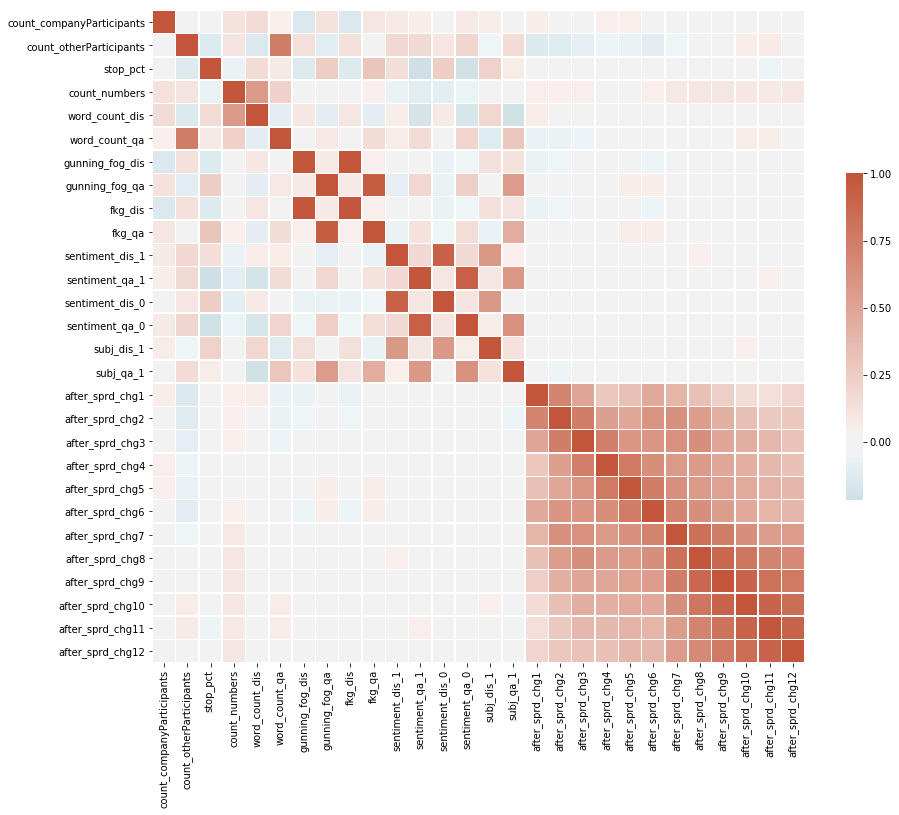

In [106]:
# Generate a mask for the upper triangle
#mask = np.zeros_like(df_cor, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_cor, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [107]:
df_cor.style.background_gradient()

,count_companyParticipants,count_otherParticipants,stop_pct,count_numbers,word_count_dis,word_count_qa,gunning_fog_dis,gunning_fog_qa,fkg_dis,fkg_qa,sentiment_dis_1,sentiment_qa_1,sentiment_dis_0,sentiment_qa_0,subj_dis_1,subj_qa_1,after_sprd_chg1,after_sprd_chg2,after_sprd_chg3,after_sprd_chg4,after_sprd_chg5,after_sprd_chg6,after_sprd_chg7,after_sprd_chg8,after_sprd_chg9,after_sprd_chg10,after_sprd_chg11,after_sprd_chg12
count_companyParticipants,1,-0.0200445,0.0274407,0.119623,0.159321,0.0444465,-0.140595,0.126058,-0.140423,0.0996359,0.0704824,0.0524608,0.0374972,0.0695632,0.0553677,0.00825837,0.0544934,0.0397231,0.0345283,0.048841,0.0445438,0.0296575,0.00872507,0.00829852,-0.00313679,-0.00259757,-0.0111125,-0.0254306
count_otherParticipants,-0.0200445,1,-0.128837,0.113688,-0.141265,0.740152,0.132622,-0.107754,0.132108,-0.0377575,0.180384,0.169482,0.106246,0.20162,-0.0441323,0.157719,-0.133218,-0.11804,-0.0832306,-0.0504641,-0.0745095,-0.0944258,-0.0436496,-0.0116602,0.0309416,0.0603163,0.0689298,0.0214784
stop_pct,0.0274407,-0.128837,1,-0.0629619,0.157671,0.0726474,-0.126904,0.25876,-0.127564,0.306513,0.143868,-0.215399,0.257222,-0.19364,0.212997,0.0623222,0.032682,0.00126168,0.0125516,0.0180402,0.0334457,0.0333055,0.00726462,0.00576,-0.0208236,-0.0256214,-0.0464503,-0.00764324
count_numbers,0.119623,0.113688,-0.0629619,1,0.569786,0.224007,0.0255795,0.0392752,0.0277081,0.04545,-0.068019,-0.110768,-0.104949,-0.0581333,-0.028325,-0.0192077,0.049246,0.0504539,0.0443084,0.0359053,0.0202912,0.0448638,0.0807894,0.101639,0.0940437,0.0929158,0.0830901,0.0978427
word_count_dis,0.159321,-0.141265,0.157671,0.569786,1,-0.0922634,0.0901794,-0.0972138,0.0934428,-0.101038,0.057569,-0.182641,0.0709244,-0.166598,0.189774,-0.194681,0.0589714,0.0360483,0.024437,-0.00654323,-0.00836267,0.00202242,0.0326054,0.0304039,0.0154619,0.0017527,0.00066035,0.0305484
word_count_qa,0.0444465,0.740152,0.0726474,0.224007,-0.0922634,1,0.0294423,0.0824055,0.0291385,0.156899,0.0574745,0.159872,0.0166822,0.203682,-0.116147,0.290098,-0.0601219,-0.0587482,-0.0479914,-0.00326715,-0.0171485,-0.035854,-0.00914409,0.00382002,0.0393898,0.0579234,0.0552084,0.0381287
gunning_fog_dis,-0.140595,0.132622,-0.126904,0.0255795,0.0901794,0.0294423,1,0.0730161,0.999984,0.0463061,-0.0101418,0.0357545,-0.0626135,-0.0437937,0.130917,0.117271,-0.0627604,-0.0399047,-0.0349197,-0.028494,-0.0301869,-0.0461131,-0.015275,-0.0113257,0.00686466,0.0231636,0.0332257,0.0157083
gunning_fog_qa,0.126058,-0.107754,0.25876,0.0392752,-0.0972138,0.0824055,0.0730161,1,0.0729187,0.948768,-0.0859005,0.196636,-0.0756503,0.238759,-0.0333291,0.559826,0.0339567,0.0286291,0.0356854,0.0405666,0.0535898,0.0510438,0.0177738,0.00190036,-0.0166062,-0.0278308,-0.0234286,-0.0176773
fkg_dis,-0.140423,0.132108,-0.127564,0.0277081,0.0934428,0.0291385,0.999984,0.0729187,1,0.0464067,-0.0109856,0.035225,-0.0635849,-0.044188,0.130511,0.116535,-0.062674,-0.0398493,-0.0349264,-0.0285903,-0.030407,-0.0461904,-0.0152215,-0.0112443,0.0069451,0.0232344,0.033415,0.0159353
fkg_qa,0.0996359,-0.0377575,0.306513,0.04545,-0.101038,0.156899,0.0463061,0.948768,0.0464067,1,-0.0627513,0.122145,-0.0403746,0.151618,-0.0602761,0.450976,0.0365341,0.0316526,0.032808,0.0362618,0.0577866,0.0507763,0.0195312,0.00371493,-0.0108097,-0.0229834,-0.0242346,-0.0181452


c:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


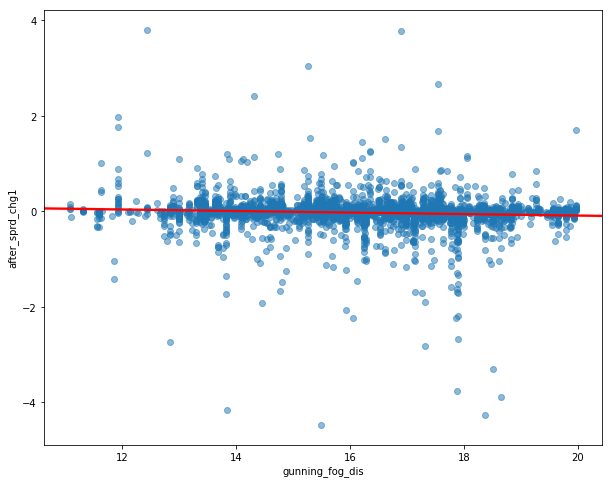

In [108]:
plt.figure(figsize=(10,8))
#plt.scatter(x='fkg_qa', y='sentiment_qa_0', data=df_ec.query('fkg_qa < 25'))
sns.regplot(x='gunning_fog_dis', y='after_sprd_chg1',
            data=df_input2.query('(after_sprd_chg8 != 0 and after_sprd_chg8 != @nan) and 5 < gunning_fog_dis < 20'), 
            scatter_kws={'alpha': 0.5}, line_kws={'color':'red'},)
            #x_bins=10)
#plt.ylim(0.12,0.18)
plt.show()

c:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


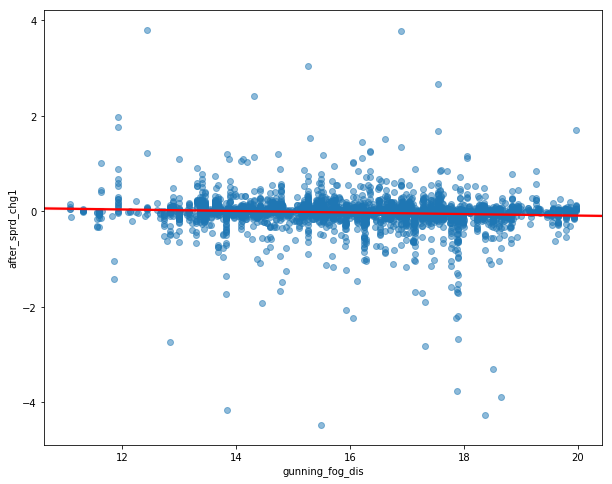

In [109]:
plt.figure(figsize=(10,8))
#plt.scatter(x='fkg_qa', y='sentiment_qa_0', data=df_ec.query('fkg_qa < 25'))
sns.regplot(x='gunning_fog_dis', y='after_sprd_chg1',
            data=df_input2.query('(after_sprd_chg8 != 0 and after_sprd_chg8 != @nan) and 5 < gunning_fog_dis < 20'), 
            scatter_kws={'alpha': 0.5}, line_kws={'color':'red'},)
            #x_bins=10)
#plt.ylim(0.12,0.18)
plt.show()

c:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


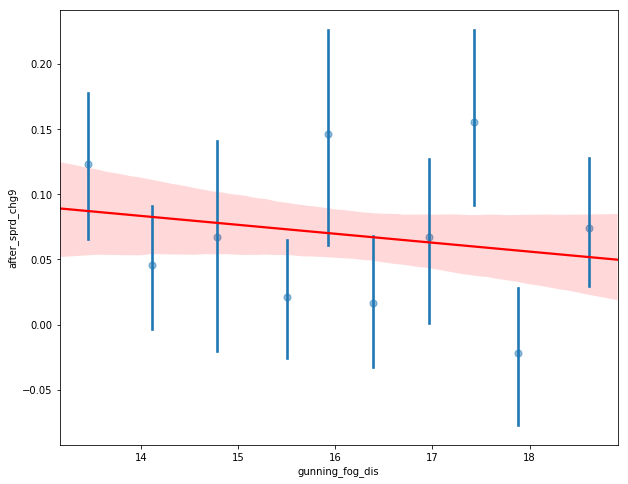

In [110]:
plt.figure(figsize=(10,8))
#plt.scatter(x='fkg_qa', y='sentiment_qa_0', data=df_ec.query('fkg_qa < 25'))
sns.regplot(x='gunning_fog_dis', y='after_sprd_chg9',
            data=df_input2.query('(after_sprd_chg8 != 0 and after_sprd_chg8 != @nan) and 5 < gunning_fog_dis < 20'), 
            scatter_kws={'alpha': 0.5}, line_kws={'color':'red'},
            #truncate=True,
            x_bins=10)
#plt.ylim(0.12,0.18)
plt.show()

c:\anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


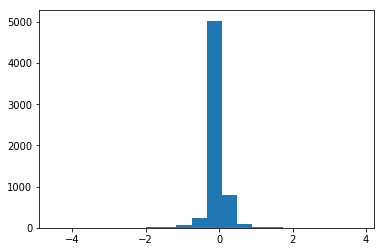

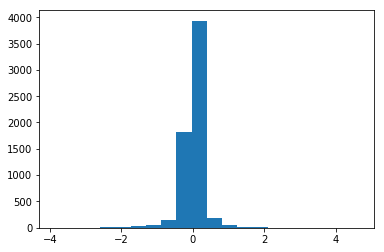

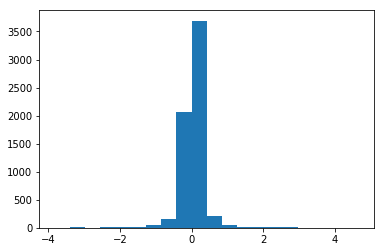

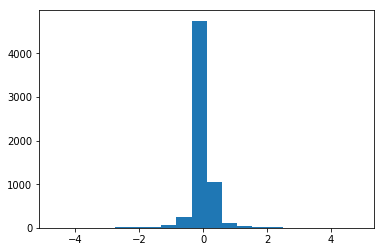

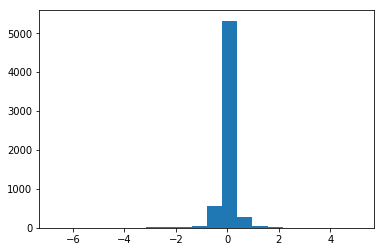

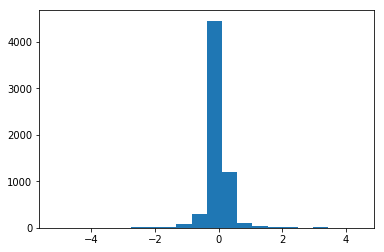

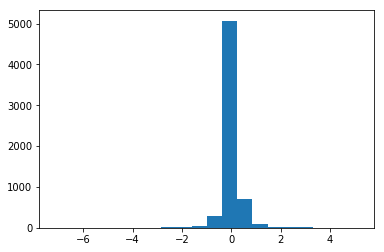

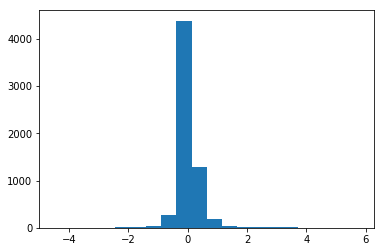

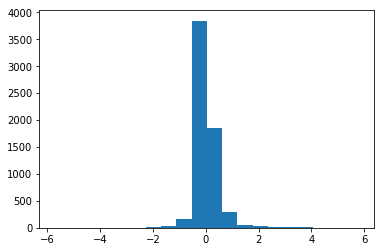

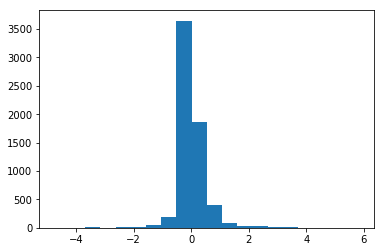

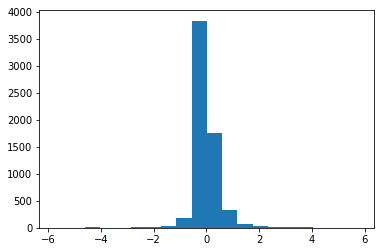

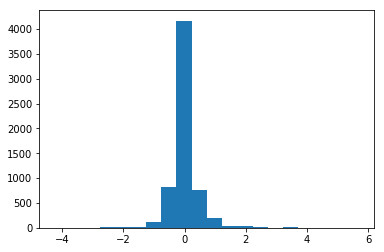

In [111]:
chg = ['after_sprd_chg1',
       'after_sprd_chg2', 'after_sprd_chg3', 'after_sprd_chg4',
       'after_sprd_chg5', 'after_sprd_chg6', 'after_sprd_chg7',
       'after_sprd_chg8', 'after_sprd_chg9', 'after_sprd_chg10',
       'after_sprd_chg11', 'after_sprd_chg12']
for c in chg:
    plt.hist(df_input2[c], bins=20)
    plt.show()

In [ ]:
plt.figure(figsize=(10,8))
sns.regplot(x=np.log(df_input2['before_spreadw3']), y=df_input2['after_sprd_chg3'])
plt.show()

## Document Similarity

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [113]:
tfidf = TfidfVectorizer().fit_transform(df_ec['text_dis_clean'])
# no need to normalize, since Vectorizer will return normalized tf-idf
pairwise_similarity = tfidf * tfidf.T

In [114]:
df_cos_sim = pd.DataFrame(pairwise_similarity.A, index=df_ec['file_name'], columns=df_ec['file_name'])
df_cos_sim.index.name = 'file'
df_cos_sim = df_cos_sim.where(np.triu(np.ones(df_cos_sim.shape)).astype(np.bool))
df_cos_sim = df_cos_sim.stack().reset_index()
df_cos_sim.columns = ['Row','Column','Value']
df_cos_sim.query('Value < 0.8 and Value > 0.7')

,Row,Column,Value
683,20170802_8303_EarningsCall_FS00000000236932122...,20171101_8303_EarningsCall1_FS0000000023796354...,0.715993
5718,20170802_BDC_EarningsCall_FS000000002368972975...,20171101_BDC_EarningsCall_FS000000002379485239...,0.748717
6974,20170802_BG_EarningsCall_FS000000002363796472.pdf,20171101_BG_EarningsCall1_DN000000002379477601...,0.754543
6975,20170802_BG_EarningsCall_FS000000002363796472.pdf,20171101_BG_EarningsCall_FS000000002379482707.pdf,0.783025
6976,20170802_BG_EarningsCall_FS000000002363796472.pdf,20171101_BG_EarningsCall_FS000000002379482713.pdf,0.705439
8228,20170802_BG_EarningsCall_FS000000002363796496.pdf,20171101_BG_EarningsCall1_DN000000002379477601...,0.711606
8229,20170802_BG_EarningsCall_FS000000002363796496.pdf,20171101_BG_EarningsCall_FS000000002379482707.pdf,0.731935
8230,20170802_BG_EarningsCall_FS000000002363796496.pdf,20171101_BG_EarningsCall_FS000000002379482713.pdf,0.743450
10775,20170802_DBK_EarningsCall_FS000000002363334541...,20171102_DBK_EarningsCall_FS000000002379943702...,0.739945
14486,20170802_EQIX_EarningsCall_FS00000000236350262...,20171101_EQIX_EarningsCall1_FS0000000023796562...,0.792756


In [115]:
df_cos_sim['Row_Date'] = df_cos_sim['Row'].apply(lambda x: x[:8])
df_cos_sim['Col_Date'] = df_cos_sim['Column'].apply(lambda x: x[:8])

In [116]:
df_cos_sim['Row_Ticker'] = df_cos_sim['Row'].apply(lambda x: re.search(string=x[9:], pattern='^[^_]+(?=_)').group(0))
df_cos_sim['Col_Ticker'] = df_cos_sim['Column'].apply(lambda x: re.search(string=x[9:], pattern='^[^_]+(?=_)').group(0))

In [117]:
df_cos_sim = df_cos_sim.query('Row != Column')
file_to_remove = list(df_cos_sim.query('Col_Ticker == Row_Ticker and Row_Date==Col_Date and Value > 0.8')['Column'])
df_cos_sim = df_cos_sim.query('Col_Ticker == Row_Ticker and Row_Date!=Col_Date and Value <= 0.8')

In [118]:
df_ec = df_ec[~df_ec['file_name'].isin(file_to_remove)]

In [119]:
df_cos_sim['Col_TD'] = df_cos_sim['Col_Ticker'] + '_' + df_cos_sim['Col_Date']
df_cos_sim['Row_TD'] = df_cos_sim['Row_Ticker'] + '_' + df_cos_sim['Row_Date'] 

In [120]:
df_cos_sim['Col_Ticker'] + '_' + df_cos_sim['Col_Date']

683       8303_20171101
684       8303_20171101
1217      8303_20180131
1218      8303_20180131
2125       AKE_20171109
3236      APTV_20171102
3237      APTV_20171102
4493      APTV_20171102
4494      APTV_20171102
5717       BDC_20171101
5718       BDC_20171101
6974        BG_20171101
6975        BG_20171101
6976        BG_20171101
8228        BG_20171101
8229        BG_20171101
8230        BG_20171101
9446        CG_20171031
9447        CG_20171031
10589      DBK_20171026
10590      DBK_20171026
10775      DBK_20171102
10776      DBK_20171102
11840      DBK_20171026
11841      DBK_20171026
12026      DBK_20171102
12027      DBK_20171102
14486     EQIX_20171101
14487     EQIX_20171101
14488     EQIX_20171101
              ...      
670659     SAN_20180131
670660     SAN_20180131
671156     SAN_20180131
671157     SAN_20180131
703784     RCL_20180124
703785     RCL_20180124
704209     RCL_20180124
704210     RCL_20180124
721833     CPS_20171205
728697     JCI_20180131
728698     JCI_2

# Bag of Words

In [123]:
from keras.preprocessing.text import Tokenizer

In [125]:
k_tokenizer = Tokenizer()
k_tokenizer.fit_on_texts(df_ec['text'])

In [128]:
k_tokenizer.document_count

835

In [131]:
k_tokenizer.word_index

{'prosecution': 30116,
 'cîroc': 17739,
 'broadcast': 4567,
 'bowie': 24255,
 'headquarter': 7995,
 'reclarify': 47072,
 '67': 3195,
 'dedication': 5438,
 'phosphates': 46150,
 'nib': 33627,
 'ir': 2181,
 'jalisco': 18665,
 'privilege': 11078,
 'concerning': 2858,
 'catlin': 18637,
 'karlsruhe': 32644,
 'powerhouse': 17836,
 'qualified': 5249,
 'wilkins': 13971,
 'boxholm': 25435,
 'writable': 31377,
 'helicopters': 5642,
 'retentional': 40255,
 'fontainebleau': 21846,
 'ditch': 28871,
 'elatch': 35593,
 'cfr': 47362,
 'regional': 1591,
 'admix': 24937,
 'shift': 958,
 'backyards': 47456,
 'mailmark': 44807,
 'international': 629,
 "event's": 45438,
 '966': 39108,
 'june': 851,
 'grantors': 40063,
 'indium': 33504,
 'newsfeed': 44615,
 'alimentos': 35393,
 't3000': 24081,
 'regions': 933,
 'vinythai': 43274,
 'deteriorate': 12076,
 'consigning': 44286,
 'johannesburg': 35606,
 'evolved': 5309,
 'damages': 8645,
 'areas': 455,
 'rav': 17687,
 'seraina': 20469,
 'peddy': 10275,
 'hew': 4

In [133]:
encoded_txt = k_tokenizer.texts_to_matrix(df_ec['text'], mode='binary')

(835, 47602)

## External API

In [421]:
import indicoio
indicoio.config.api_key = '97ecc8746d2b9b53c829984c560394a2'

# single example
indicoio.sentiment("I love writing code!")

0.9819219949985644

In [428]:
indicoio.emotion(df_ec['text_dis_clean'][0])['anger']

0.14125637710094452

In [431]:
df_ec['indico_sent_dis'] = df_ec['text_dis_clean'].apply(lambda x: indicoio.sentiment(x))

In [432]:
df_ec['indico_sent_qa'] = df_ec['text_qa_clean'].apply(lambda x: indicoio.sentiment(x))

In [437]:
psave = open('df_ec.p', 'wb')
pickle.dump(df_ec, psave)
psave.close()

In [433]:
emot_dis = list(df_ec['text_dis_clean'].apply(lambda x: indicoio.emotion(x)))
emot_qa = list(df_ec['text_qa_clean'].apply(lambda x: indicoio.emotion(x)))

In [435]:
psave = open('emot_dis.p', 'wb')
pickle.dump(emot_dis, psave)
psave.close()

In [436]:
psave = open('emot_qa.p', 'wb')
pickle.dump(emot_qa, psave)
psave.close()

In [434]:
pd.DataFrame

[{'anger': 0.14125637710094452,
  'fear': 0.18297037482261658,
  'joy': 0.1875438541173935,
  'sadness': 0.42602184414863586,
  'surprise': 0.062207549810409546},
 {'anger': 0.06775334477424622,
  'fear': 0.3568117022514343,
  'joy': 0.34180110692977905,
  'sadness': 0.13280817866325378,
  'surprise': 0.10082565993070602},
 {'anger': 0.09530670195817947,
  'fear': 0.29116711020469666,
  'joy': 0.18763867020606995,
  'sadness': 0.29441893100738525,
  'surprise': 0.13146860897541046},
 {'anger': 0.06881078332662582,
  'fear': 0.2546005845069885,
  'joy': 0.42193403840065,
  'sadness': 0.17593979835510254,
  'surprise': 0.07871474325656891},
 {'anger': 0.050120577216148376,
  'fear': 0.7664022445678711,
  'joy': 0.10038834810256958,
  'sadness': 0.07269276678562164,
  'surprise': 0.010396098718047142},
 {'anger': 0.04823005944490433,
  'fear': 0.3906251788139343,
  'joy': 0.10019780695438385,
  'sadness': 0.31302303075790405,
  'surprise': 0.14792396128177643},
 {'anger': 0.13283798098564

In [430]:
df_ec['text_qa_clean'][:10].apply(lambda x: indicoio.sentiment(x))

0    0.677876
1    0.951526
2    0.840817
3    0.896728
4    0.830982
5    0.870940
6    0.919669
7    0.956952
8    0.983173
9    0.970057
Name: text_qa_clean, dtype: float64

In [ ]:
%timeit parseEarningCall(pdfPath, '20170802_DBK_EarningsCall_FS000000002363334541.pdf')

In [ ]:
%timeit parseEarningCall2(pdfPath, '20170802_DBK_EarningsCall_FS000000002363334541.pdf')

In [ ]:
re.search(r'Company Ticker\: (.*?)Date\:', data).group(1)

In [ ]:
re.search(r'Date\: (.*?)Event Description\:', data).group(1)


In [ ]:
re.search(r'Market Cap\: (.*?)Current PX\:', data).group(1), \
re.search(r'Current PX\: (.*?)YTD Change\(\$\)\:', data).group(1), \
re.search(r'YTD Change\(\$\)\: (.*?)YTD Change\(\%\)\:', data).group(1), \
re.search(r'YTD Change\(\%\)\: (.*?)Bloomberg Estimates\s\-\sEPS', data).group(1)


In [ ]:
x['file']

In [ ]:
print(re.sub('\nCompany Name\:(.*?)[\\x0c]', '\x0c', data))
#data.split('\x0c')

In [ ]:
pdfPath = "Fixedicomecalls/20180223_ONEX_EarningsCall_FS000000002403447620.pdf"
os.path.isfile(pdfPath)


In [ ]:
reader = PyPDF2.PdfFileReader(open("Fixedicomecalls/20180223_ONEX_EarningsCall_FS000000002403447620.pdf", 'rb'))
pg0 = reader.getPage(0)
print(pg0.extractText())

In [ ]:
pg0.extractText()

In [ ]:
re.split(r"(\nQuestions And Answers\n|\nQ\&A\n)", data.decode("utf-8"))

In [ ]:
splitter = r"(\n\x0cQuestions And Answers\n|\nQuestions And Answers\n|\nQ\&A\n|\nQUESTION AND ANSWER SECTION\n|\n\x0cQ&A\n|\n\x0cQUESTION AND ANSWER SECTION\n)"

df_ec['text_discussion'] = df_ec['text']. \
                            apply(lambda x: \
                                  re.split(splitter, x))
#open the call for questions.
#we are ready for questions.

In [ ]:
df_ec[['text_discussion', 'text_qa']] = df_ec['text'].str.split(splitter, expand=True).iloc[:,[0,2]]
df_ec.head()

In [ ]:
t = df_ec['text'].apply(lambda x: re.split(splitter, x))
list(t)[:3]

In [116]:
from urllib import request
from bs4 import BeautifulSoup
import requests
from fake_useragent import UserAgent

In [88]:
quote_page = 'http://www.bloomberg.com/quote/1:HK'
page = request.urlopen(quote_page, )
soup = BeautifulSoup(page, 'html.parser')
name_box = soup.find('h1', attrs={'class': 'name'})
name = name_box.text.strip()

AttributeError: 'NoneType' object has no attribute 'text'

In [123]:
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.2 (KHTML, like Gecko) Chrome/22.0.1216.0 Safari/537.2'}
cookies = {
    '_ga':'GA1.2.1716126567.1544304570',
    '_gcl_au': '1.1.1677957866.1544304570',
    '_gid': 'GA1.2.216729865.1544304570',
    'agent_id': '7f3bee89-c122-482b-9c78-7707c1306f19',
    'notice_behavior': 'expressed,eu',
    'session_id': 'a60d9c0c-44ca-4fa7-b275-062bb7ab11ec',
    'session_key': '0475f1b23cd67b50b7f73b317a63279c863daf89',
    '_tbc': '%7Bjzx%7Dt_3qvTkEkvt3AGEeiiNNgMMct7TE64ZiGMOGRMx2ogZbEqANwM-S6jxQyf5IWWoxVWEien1s32AkR_b1mWpE47EvwaLY1KlajI83JzZnHqK23_l0n6zCkWiFDxXwSWcEjylU0Z664w9lha1BgkmqDg',
    'xbc': '%7Bjzx%7DiZyv4aqKYKQTcKsQ_PY2r2duZLjzFWvzdOIWPPiNWQaw41bxZKVK6jxstfeEqlSOcBwgYmeTovmnwIm1CPGlAv6Dp4SkthHC7f4_cD6vXuQZOs_4aKu2V3_6LRip4bN3qcgC7ep2UbDmnkB0KfKD2uc1UkxjUqVenIANKoRWZMqikjBEeUS6mBk89q9aqYfF-mxDuPxZkp2RSchVbaNqGhG6m38GiBEk19vEnqhU173ecypKfiHL9s6ICLHF0V-z90Yhy9MCt2EnyPWsavYLF1DVnh1QScJZsiVjipSJOZKkG4-i8fKXj-KFK0GMUDgn3yJTTd7xr9qzOdR9u4CrIpdTG7eKpGCqE1V9ESXcmG8',
    '_gads': 'ID=59d516ac5390899a:T=1544306961:S=ALNI_MYBhW79RbQGcDiN0XiSca_XXlNu7A'
}

ua = UserAgent()

hdr = {'User-Agent': 'Mozilla/5.0 (X11; CrOS i686 2268.111.0) AppleWebKit/536.11 (KHTML, like Gecko) Chrome/20.0.1132.57 Safari/536.11',
      'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
      'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
      'Accept-Encoding': 'none',
      'Accept-Language': 'en-US,en;q=0.8',
      'Connection': 'keep-alive'}

html_http_response = requests.get('http://www.bloomberg.com/quote/1:HK', headers=hdr,cookies=cookies)
data = html_http_response.text

In [124]:
data

'<!doctype html>\n<html>\n<head>\n    <title>Bloomberg - Are you a robot?</title>\n    <meta name="viewport" content="width=device-width, initial-scale=1">\n    <link rel="stylesheet" type="text/css" href="https://assets.bwbx.io/font-service/css/BWHaasGrotesk-55Roman-Web,BWHaasGrotesk-75Bold-Web,BW%20Haas%20Text%20Mono%20A-55%20Roman/font-face.css">\n    <style rel="stylesheet" type="text/css">\n        html, body, div, span, applet, object, iframe,\n        h1, h2, h3, h4, h5, h6, p, blockquote, pre,\n        a, abbr, acronym, address, big, cite, code,\n        del, dfn, em, img, ins, kbd, q, s, samp,\n        small, strike, strong, sub, sup, tt, var,\n        b, u, i, center,\n        dl, dt, dd, ol, ul, li,\n        fieldset, form, label, legend,\n        table, caption, tbody, tfoot, thead, tr, th, td,\n        article, aside, canvas, details, embed,\n        figure, figcaption, footer, header, hgroup,\n        menu, nav, output, ruby, section, summary,\n        time, mark, audio, 